# Pengembangan *physics informed neural networks* (PINNs) untuk penyelesaian PDP

# 1. Import *Library* dan *Package* yang diperlukan.

Kode dapat dijalankan dengan TensorFlow versi `2.5.x`.
Implementasi model dilakukan dengan *library* [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html) dan *library* untuk *machine learning* [TensorFlow](https://www.tensorflow.org/).

Telah dikembangkan implementasi *class* untuk pembuatan PINN sebagai objek dari Keras pada sebuah *package* yang disimpan dalam *file* `PINNPDESolver.py`.

Komputasi dilakukan pada Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Current Working Directory
dir = '/content/drive/My Drive/Tugas Akhir/Colab'

import sys
sys.path.insert(0, dir)

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Physics-Informed Neural Network
import PINNPDESolver as pinn

# Import Combined Learning Rate Decay
from CombinedDecay import CombinedDecay

# Import time
from time import time

# Import matplotlib for plots
import matplotlib.pyplot as plt

# Creating tables
import pandas as pd
from tabulate import tabulate

Mounted at /content/drive


In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 24,               # LaTeX default is 10pt font.
    "font.size": 24,
    "legend.fontsize": 24,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
plt.rcParams.update(pgf_with_latex)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [ ]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# 2. Persamaan Korteweg-de Vries (KdV) 1-Soliton dan Transformasi menjadi *Loss Function*

Persamaan KdV yang akan digunakan adalah

$$
\begin{equation}
    u_t - 6uu_{x} + u_{xxx} = 0, \quad -\infty<x<\infty, \quad t>0
\end{equation}.
$$
Diberikan *initial condition* (IC)
$$
\begin{equation}
    u(x,\,0) = -2sech^2(x).
\end{equation}
$$
Solusi unik masalah ini adalah
$$
\begin{equation}
	        u(x,\;t) = -2sech^2(x-4t).
\end{equation}
$$

In [ ]:
lambda_star = [-6, 1]

# Define initial condition
def fun_u_0(x):
    return -2 * 1/(tf.math.cosh(x))**2

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, lambd = lambda_star):
    return u_t + lambd[0] * u * u_x + lambd[1] * u_xxx

In [ ]:
# Solusi Eksplisit
def u_expl(t, x):
    """Solusi eksplisit persamaan KdV."""
    return -2 * 1/(np.cosh(x-4*t))**2

In [ ]:
# Set boundary
tmin = -1.
tmax = 1.
xmin = -10.
xmax = 10.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Masalah Maju

## 1. Persiapan Pemodelan

### Pembangkitan Data *Training* dan *Collocation Points*

Penentuan Jumlah Data

In [ ]:
# Set number of data points
N_0 = 50
# N_0 = 50+50
N_r = 10000

Pembangkitan Data

In [ ]:
plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:
  # Draw uniform sample points for initial boundary data -> titik di batas domain, definisi domain adalah bidang (x,t)
  t_0 = tf.zeros((N_0,1), dtype=DTYPE)
  # t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
  x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
  X_0 = tf.concat([t_0, x_0], axis=1)

  # Evaluate initial condition at x_0
  u_0 = fun_u_0(x_0)  

  # Collect boundary and inital data in lists
  X_data = [X_0]
  u_data = [u_0]

  # Draw uniformly sampled collocation points -> titik interior domain
  t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
  x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
  X_r = tf.concat([t_r, x_r], axis=1)

elif plot == False:
  X_data, u_data, fig = pinn.generate_training_data(N_0, N_0, fun_u_0, fun_u_0, lb, ub)
  X_r = pinn.generate_collocation_points(N_r, lb, ub)

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

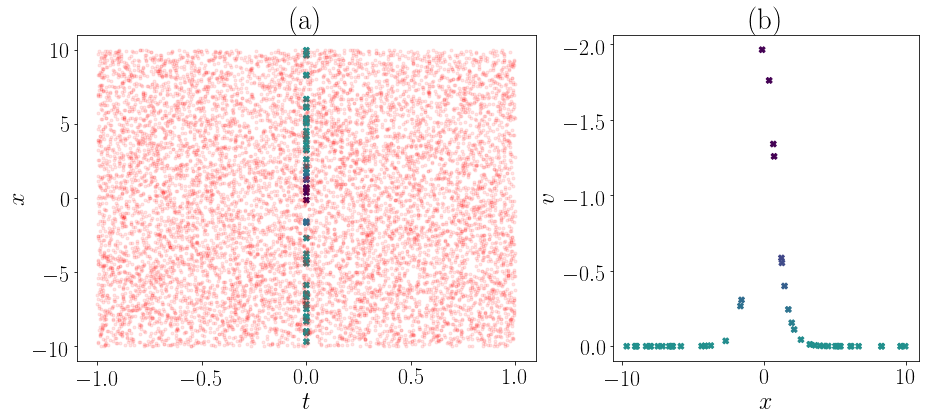

In [ ]:
if plot == True:
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15.1, 6),
                                 gridspec_kw={
                                     'width_ratios': [9, 6],
                                     'wspace': 0.2})
  
  ax1.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax1.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
  ax1.set_xlabel('$t$')
  ax1.set_ylabel('$x$')
  ax1.set_title('(a)')

  ax2.scatter(x_0, u_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax2.set_xlabel('$x$')
  ax2.set_ylabel('$v$')
  ax2.invert_yaxis()
  ax2.set_title('(b)')

  plt.savefig('kdv_eqn_fwd_train.pdf', dpi=600, bbox_inches='tight', facecolor='none')
  plt.show()

### Persiapan Arsitektur PINN

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

Pada *hidden layer* pertama, terdapat $2 \times 20 = 40$ parameter bobot dan $20$ parameter bias. Pada 9 *hidden layer* selanjutnya, terdapat $20 \times 20 = 400$ parameter bobot dan $20$ parameter bias dalam setiap *layer*. Di *output layer* yang terhubung *hidden layer* terakhir, terdapat $1 \times 20 = 20$ parameter bobot dan $20$ parameter bias. 

Maka, terdapat sejumlah
    \begin{align*}
        1 \times (40+20) + 9 \times (400+20) + 1 \times (20+20) = 3880
    \end{align*}
parameter yang dapat ditentukan dan diperbarui pada setiap *epoch* dalam PINN.

Akan dibuat sebuah model yang mana bobot-bobot inisialnya akan dimuat pada setiap model yang akan dikembangkan dengan *optimizer* L-BFGS, SGD, dan Adam. Hal ini dilakukan agar analisis hasil kinerja dapat dilakukan dengan adil dikarenakan proses *learning* yang dilakukan dengan kondisi yang sama untuk setiap kasus (inisialisai model *apple to apple*).

In [ ]:
# Setting parameters for model's architecture
arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}

In [ ]:
tf.random.set_seed(1)

# Initializing model weights which will be copied to other models
model = pinn.PINN_NeuralNet(lb, ub, **arch)
model.build(input_shape=(None,2))

In [ ]:
model_LBFGS = pinn.PINN_NeuralNet(lb, ub, **arch)
model_LBFGS.build(input_shape=(None,2))

model_SGD_exp = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_exp.build(input_shape=(None,2))

model_SGD_pw = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_pw.build(input_shape=(None,2))

model_SGD_comb = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_comb.build(input_shape=(None,2))

model_Adam_exp = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_exp.build(input_shape=(None,2))

model_Adam_pw = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_pw.build(input_shape=(None,2))

model_Adam_comb = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_comb.build(input_shape=(None,2))

In [ ]:
# Copying weights
model_LBFGS.set_weights(model.get_weights())
model_SGD_exp.set_weights(model.get_weights())
model_SGD_pw.set_weights(model.get_weights())
model_SGD_comb.set_weights(model.get_weights())
model_Adam_exp.set_weights(model.get_weights())
model_Adam_pw.set_weights(model.get_weights())
model_Adam_comb.set_weights(model.get_weights())

### Persiapan Perhitungan *Loss Function*

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the kdv equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [ ]:
def get_r(t, x, model, fun_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape1:  
        
        tape1.watch(x)        
        with tf.GradientTape(persistent=True) as tape2:
          
          tape2.watch(x)
          with tf.GradientTape(persistent=True) as tape3:
          
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape3.watch(t)
            tape3.watch(x)
          
            # Determine residual 
            u = model(tf.stack([t[:,0], x[:,0]], axis=1))

          # Compute gradient u_x and u_t
          u_t = tape3.gradient(u, t)
          u_x = tape3.gradient(u, x)       
        
        u_xx = tape2.gradient(u_x, x)
    
    u_xxx = tape1.gradient(u_xx, x)

    del tape1
    del tape2
    del tape3

    return fun_r(t, x, u, u_t, u_x, u_xx, u_xxx)

## 2. Persiapan *Optimizer*

In [ ]:
# Preparing learning rates
lr_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=150,
    decay_rate=0.9)

lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,4000],
                                                             [1e-2,1e-3,5e-4,2.5e-5])

lr_comb = CombinedDecay(boundaries=[3000,4000],
                        initial_learning_rate=1e-2,
                        decay_steps=150,
                        decay_rate=0.9,
                        values_steps=2)

# Preparing the optimizer
optim_SGD_exp = tf.keras.optimizers.SGD(learning_rate=lr_exp)
optim_Adam_exp = tf.keras.optimizers.Adam(learning_rate=lr_exp)

optim_SGD_pw = tf.keras.optimizers.SGD(learning_rate=lr_pw)
optim_Adam_pw = tf.keras.optimizers.Adam(learning_rate=lr_pw)

optim_SGD_comb = tf.keras.optimizers.SGD(learning_rate=lr_comb)
optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb)

In [ ]:
lr_comb.get_config()

{'initial_learning_rate': 0.01,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [3000, 4000],
 'values': [0.0012157665459056935,
  0.0006078832729528468,
  0.0003039416364764234],
 'values_steps': [2, 2],
 'name': None}

## 3. *Training* Model dan Prediksi Solusi

In [ ]:
# Setting learning timeout
timeout = 100

# Initilize PINN solver
solver_LBFGS = pinn.PINN_PDESolver(model_LBFGS, X_r, fun_r, get_r)

solver_SGD_exp = pinn.PINN_PDESolver(model_SGD_exp, X_r, fun_r, get_r)
solver_SGD_pw = pinn.PINN_PDESolver(model_SGD_pw, X_r, fun_r, get_r)
solver_SGD_comb = pinn.PINN_PDESolver(model_SGD_comb, X_r, fun_r, get_r)

solver_Adam_exp = pinn.PINN_PDESolver(model_Adam_exp, X_r, fun_r, get_r)
solver_Adam_pw = pinn.PINN_PDESolver(model_Adam_pw, X_r, fun_r, get_r)
solver_Adam_comb = pinn.PINN_PDESolver(model_Adam_comb, X_r, fun_r, get_r)

###LBFGS

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_LBFGS.solve_with_ScipyOptimizer(X_data, u_data, timeout=timeout, method='L-BFGS-B')

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: l_u = 2.46773079e-01 l_f = 6.54747337e-02 loss = 3.12247813e-01
It 00050: l_u = 1.97043912e-02 l_f = 1.24525828e-02 loss = 3.21569741e-02
It 00100: l_u = 2.71598343e-03 l_f = 3.05672875e-03 loss = 5.77271217e-03
It 00150: l_u = 4.68989601e-05 l_f = 9.12740012e-04 loss = 9.59638972e-04
It 00200: l_u = 5.00204915e-05 l_f = 4.17805772e-04 loss = 4.67826263e-04
It 00250: l_u = 3.36084922e-05 l_f = 2.91932432e-04 loss = 3.25540925e-04
It 00300: l_u = 1.66140962e-05 l_f = 2.46226380e-04 loss = 2.62840476e-04
It 00350: l_u = 1.13434216e-05 l_f = 1.73479028e-04 loss = 1.84822449e-04
It 00400: l_u = 1.01255500e-05 l_f = 1.05678882e-04 loss = 1.15804432e-04
It 00450: l_u = 3.52556526e-06 l_f = 8.63125824e-05 loss = 8.98381477e-05
It 00500: l_u = 1.50391134e-06 l_f = 6.29779970e-05 loss = 6.44819083e-05
It 00550: l_u = 3.12380871e-06 l_f = 5.40558467e-05 loss = 5.71796554e-05
It 00600: l_u = 1.68737824e-06 l_f = 4.72811189e-05 loss = 4.89684971e-05
It 00650: l_u = 2.19534923e-06 l_f = 4

### SGD

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_SGD_exp.solve_with_TFoptimizer(optim_SGD_exp, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 2.59964712e-01 l_f = 7.58995637e-02 loss = 3.35864276e-01
It 00050: l_u = 1.91894921e-01 l_f = 7.49808969e-04 loss = 1.92644730e-01
It 00100: l_u = 1.89883169e-01 l_f = 6.55699638e-04 loss = 1.90538868e-01
It 00150: l_u = 1.87418674e-01 l_f = 7.38928909e-04 loss = 1.88157603e-01
It 00200: l_u = 1.83988502e-01 l_f = 9.01007850e-04 loss = 1.84889510e-01
It 00250: l_u = 1.79386608e-01 l_f = 1.13313633e-03 loss = 1.80519745e-01
It 00300: l_u = 1.73518538e-01 l_f = 1.44709717e-03 loss = 1.74965635e-01
It 00350: l_u = 1.66487956e-01 l_f = 1.85864244e-03 loss = 1.68346599e-01
It 00400: l_u = 1.58728852e-01 l_f = 2.38980399e-03 loss = 1.61118656e-01
It 00450: l_u = 1.51075977e-01 l_f = 3.07932217e-03 loss = 1.54155299e-01
It 00500: l_u = 1.44494467e-01 l_f = 3.93769844e-03 loss = 1.48432165e-01
It 00550: l_u = 1.39483742e-01 l_f = 4.85047000e-03 loss = 1.44334212e-01
It 00600: l_u = 1.35839234e-01 l_f = 5.61866676e-03 loss = 1.41457900e-01
It

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_SGD_pw.solve_with_TFoptimizer(optim_SGD_pw, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 2.59964712e-01 l_f = 7.58995637e-02 loss = 3.35864276e-01
It 00050: l_u = 1.91851158e-01 l_f = 7.44860037e-04 loss = 1.92596018e-01
It 00100: l_u = 1.89730508e-01 l_f = 6.57903322e-04 loss = 1.90388411e-01
It 00150: l_u = 1.86915597e-01 l_f = 7.61309406e-04 loss = 1.87676907e-01
It 00200: l_u = 1.82704105e-01 l_f = 9.64568113e-04 loss = 1.83668673e-01
It 00250: l_u = 1.76641475e-01 l_f = 1.27722730e-03 loss = 1.77918702e-01
It 00300: l_u = 1.68459829e-01 l_f = 1.73844793e-03 loss = 1.70198277e-01
It 00350: l_u = 1.58506377e-01 l_f = 2.40729935e-03 loss = 1.60913676e-01
It 00400: l_u = 1.48368928e-01 l_f = 3.39381094e-03 loss = 1.51762739e-01
It 00450: l_u = 1.40311996e-01 l_f = 4.68512345e-03 loss = 1.44997120e-01
It 00500: l_u = 1.34901585e-01 l_f = 5.81011036e-03 loss = 1.40711695e-01
It 00550: l_u = 1.30923695e-01 l_f = 6.40290277e-03 loss = 1.37326598e-01
It 00600: l_u = 1.27309239e-01 l_f = 6.61262218e-03 loss = 1.33921862e-01
It

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_SGD_comb.solve_with_TFoptimizer(optim_SGD_comb, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 2.59964712e-01 l_f = 7.58995637e-02 loss = 3.35864276e-01
It 00050: l_u = 1.91894921e-01 l_f = 7.49808969e-04 loss = 1.92644730e-01
It 00100: l_u = 1.89883169e-01 l_f = 6.55699638e-04 loss = 1.90538868e-01
It 00150: l_u = 1.87418674e-01 l_f = 7.38928909e-04 loss = 1.88157603e-01
It 00200: l_u = 1.83988517e-01 l_f = 9.01007850e-04 loss = 1.84889525e-01
It 00250: l_u = 1.79386608e-01 l_f = 1.13313633e-03 loss = 1.80519745e-01
It 00300: l_u = 1.73518567e-01 l_f = 1.44709740e-03 loss = 1.74965665e-01
It 00350: l_u = 1.66487956e-01 l_f = 1.85864244e-03 loss = 1.68346599e-01
It 00400: l_u = 1.58728852e-01 l_f = 2.38980446e-03 loss = 1.61118656e-01
It 00450: l_u = 1.51075977e-01 l_f = 3.07932240e-03 loss = 1.54155299e-01
It 00500: l_u = 1.44494466e-01 l_f = 3.93769890e-03 loss = 1.48432165e-01
It 00550: l_u = 1.39483726e-01 l_f = 4.85047093e-03 loss = 1.44334197e-01
It 00600: l_u = 1.35839233e-01 l_f = 5.61866770e-03 loss = 1.41457900e-01
It

###Adam

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_exp.solve_with_TFoptimizer(optim_Adam_exp, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 2.59964712e-01 l_f = 7.58995637e-02 loss = 3.35864276e-01
It 00050: l_u = 1.77615471e-02 l_f = 4.34009843e-02 loss = 6.11625314e-02
It 00100: l_u = 3.26493685e-02 l_f = 4.58802236e-03 loss = 3.72373909e-02
It 00150: l_u = 2.36600041e-02 l_f = 4.19294648e-03 loss = 2.78529506e-02
It 00200: l_u = 1.21039231e-02 l_f = 2.31098337e-03 loss = 1.44149065e-02
It 00250: l_u = 6.91200653e-03 l_f = 2.82828184e-03 loss = 9.74028837e-03
It 00300: l_u = 3.66409682e-02 l_f = 5.78991324e-03 loss = 4.24308814e-02
It 00350: l_u = 1.64328152e-01 l_f = 6.61963783e-03 loss = 1.70947790e-01
It 00400: l_u = 1.61450426e-02 l_f = 4.28445125e-03 loss = 2.04294939e-02
It 00450: l_u = 4.88194870e-03 l_f = 2.64590560e-03 loss = 7.52785429e-03
It 00500: l_u = 6.14812667e-03 l_f = 1.02174398e-03 loss = 7.16987066e-03
It 00550: l_u = 3.35171297e-02 l_f = 7.81099126e-02 loss = 1.11627042e-01
It 00600: l_u = 1.19455545e-02 l_f = 2.16588797e-03 loss = 1.41114425e-02
It

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_pw.solve_with_TFoptimizer(optim_Adam_pw, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 2.59964712e-01 l_f = 7.58995637e-02 loss = 3.35864276e-01
It 00050: l_u = 2.16744887e-02 l_f = 6.79051038e-03 loss = 2.84649990e-02
It 00100: l_u = 5.31678200e-02 l_f = 1.29584849e-01 loss = 1.82752669e-01
It 00150: l_u = 2.41650566e-02 l_f = 8.16538557e-03 loss = 3.23304422e-02
It 00200: l_u = 4.59095770e-02 l_f = 1.49559444e-02 loss = 6.08655214e-02
It 00250: l_u = 6.34865535e-02 l_f = 3.35767143e-03 loss = 6.68442249e-02
It 00300: l_u = 3.19446530e-02 l_f = 1.19713712e-02 loss = 4.39160243e-02
It 00350: l_u = 7.28296242e-02 l_f = 4.12355596e-03 loss = 7.69531801e-02
It 00400: l_u = 7.68340863e-02 l_f = 1.88877098e-02 loss = 9.57217962e-02
It 00450: l_u = 4.99320962e-03 l_f = 2.71216575e-02 loss = 3.21148671e-02
It 00500: l_u = 3.11481045e-02 l_f = 3.34819918e-03 loss = 3.44963036e-02
It 00550: l_u = 9.98730606e-02 l_f = 3.63785564e-03 loss = 1.03510916e-01
It 00600: l_u = 1.14086983e-02 l_f = 2.38914555e-03 loss = 1.37978438e-02
It

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, timeout=timeout)

# Print computation time

print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 2.59964712e-01 l_f = 7.58995637e-02 loss = 3.35864276e-01
It 00050: l_u = 1.77689530e-02 l_f = 4.34076190e-02 loss = 6.11765720e-02
It 00100: l_u = 3.26329493e-02 l_f = 4.36383253e-03 loss = 3.69967818e-02
It 00150: l_u = 8.50387476e-03 l_f = 9.40329395e-03 loss = 1.79071687e-02
It 00200: l_u = 9.31381085e-03 l_f = 2.65638507e-03 loss = 1.19701959e-02
It 00250: l_u = 3.73631660e-02 l_f = 1.04759540e-02 loss = 4.78391200e-02
It 00300: l_u = 1.29306789e-01 l_f = 6.84823515e-03 loss = 1.36155024e-01
It 00350: l_u = 7.29417056e-03 l_f = 3.28417011e-02 loss = 4.01358716e-02
It 00400: l_u = 6.78918930e-03 l_f = 1.34677393e-03 loss = 8.13596323e-03
It 00450: l_u = 9.44089959e-03 l_f = 2.68428889e-03 loss = 1.21251885e-02
It 00500: l_u = 1.35876755e-02 l_f = 6.82530040e-03 loss = 2.04129759e-02
It 00550: l_u = 1.19145513e-02 l_f = 1.58697903e-01 loss = 1.70612454e-01
It 00600: l_u = 9.41909989e-03 l_f = 1.13182375e-03 loss = 1.05509236e-02
It

### Grafik *Loss*

In [ ]:
hist_LBFGS = solver_LBFGS.hist
hist_SGD_exp = solver_SGD_exp.hist
hist_SGD_pw = solver_SGD_pw.hist
hist_SGD_comb = solver_SGD_comb.hist
hist_Adam_exp = solver_Adam_exp.hist
hist_Adam_pw = solver_Adam_pw.hist
hist_Adam_comb = solver_Adam_comb.hist

NameError: ignored

In [ ]:
timeout = 100
x_LBFGS = np.linspace(0, timeout, len(hist_LBFGS))
x_SGD_exp = np.linspace(0, timeout, len(hist_SGD_exp))
x_SGD_pw = np.linspace(0, timeout, len(hist_SGD_pw))
x_SGD_comb = np.linspace(0, timeout, len(hist_SGD_comb))
x_Adam_exp = np.linspace(0, timeout, len(hist_Adam_exp))
x_Adam_pw = np.linspace(0, timeout, len(hist_Adam_pw))
x_Adam_comb = np.linspace(0, timeout, len(hist_Adam_comb))

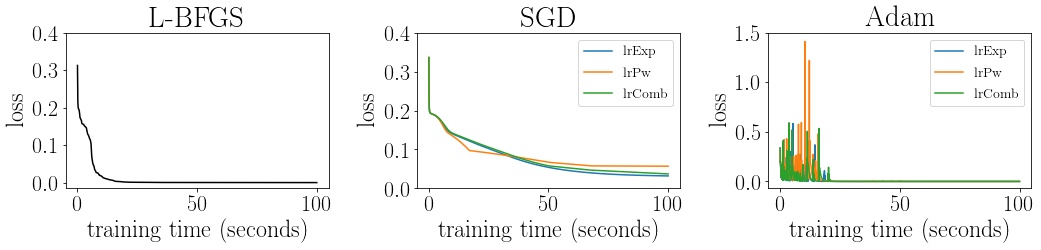

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

ax1.plot(x_LBFGS, hist_LBFGS, c='black')
ax1.set_xlabel('training time (seconds)')
ax1.set_ylabel('loss')
ax1.set_title('L-BFGS')

ax2.plot(x_SGD_exp, hist_SGD_exp)
ax2.plot(x_SGD_pw, hist_SGD_pw)
ax2.plot(x_SGD_comb, hist_SGD_comb)
ax2.legend(['lrExp', 'lrPw', 'lrComb'], fontsize=14)
ax2.set_xlabel('training time (seconds)')
ax2.set_ylabel('loss')
ax2.set_title('SGD')

ax3.plot(x_Adam_exp, hist_Adam_exp)
ax3.plot(x_Adam_pw, hist_Adam_pw)
ax3.plot(x_Adam_comb, hist_Adam_comb)
ax3.legend(['lrExp', 'lrPw', 'lrComb'], fontsize=14)
ax3.set_xlabel('training time (seconds)')
ax3.set_ylabel('loss')
ax3.set_title('Adam')

ax1.set_yticks(np.arange(0, 0.5, 0.1))
ax2.set_yticks(np.arange(0, 0.5, 0.1))
ax3.set_yticks(np.arange(0, 2, 0.5))

plt.tight_layout()
# plt.savefig('kdv_eqn_fwd_loss.pdf', dpi=600, bbox_inches='tight', facecolor='none')
# plt.savefig('kdv_eqn_fwd_loss.png', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

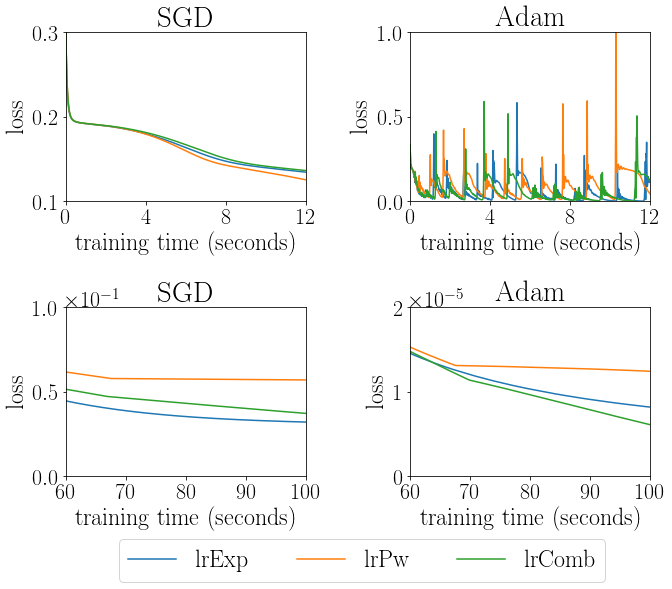

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axs[0][0].plot(x_SGD_exp, hist_SGD_exp, label='lrExp')
axs[0][0].plot(x_SGD_pw, hist_SGD_pw, label='lrPw')
axs[0][0].plot(x_SGD_comb, hist_SGD_comb, label='lrComb')
axs[0][0].set_xlabel('training time (seconds)')
axs[0][0].set_ylabel('loss')
axs[0][0].set_xlim([0, 12])
axs[0][0].set_ylim([0.1, 0.3])
axs[0][0].set_title('SGD')

axs[0][1].plot(x_Adam_exp, hist_Adam_exp, label='lrExp')
axs[0][1].plot(x_Adam_pw, hist_Adam_pw, label='lrPw')
axs[0][1].plot(x_Adam_comb, hist_Adam_comb, label='lrComb')
axs[0][1].set_xlabel('training time (seconds)')
axs[0][1].set_ylabel('loss')
axs[0][1].set_xlim([0, 12])
axs[0][1].set_ylim([0, 1])
axs[0][1].set_title('Adam')

axs[1][0].plot(x_SGD_exp, hist_SGD_exp, label='lrExp')
axs[1][0].plot(x_SGD_pw, hist_SGD_pw, label='lrPw')
axs[1][0].plot(x_SGD_comb, hist_SGD_comb, label='lrComb')
axs[1][0].set_xlabel('training time (seconds)')
axs[1][0].set_ylabel('loss')
axs[1][0].set_xlim([60, 100])
axs[1][0].set_ylim([0, 1e-1])
axs[1][0].set_title('SGD')

axs[1][1].plot(x_Adam_exp, hist_Adam_exp, label='lrExp')
axs[1][1].plot(x_Adam_pw, hist_Adam_pw, label='lrPw')
axs[1][1].plot(x_Adam_comb, hist_Adam_comb, label='lrComb')
axs[1][1].set_xlabel('training time (seconds)')
axs[1][1].set_ylabel('loss')
axs[1][1].set_xlim([60, 100])
axs[1][1].set_ylim([0, 2e-5])
axs[1][1].set_title('Adam')

axs[0][0].set_xticks(np.arange(0, 12+1, 4))
axs[0][1].set_xticks(np.arange(0, 12+1, 4))
axs[1][0].set_xticks(np.arange(60, 100+1, 10))
axs[1][1].set_xticks(np.arange(60, 100+1, 10))
axs[1][0].ticklabel_format(axis='y', scilimits=(0,0))
axs[1][1].ticklabel_format(axis='y', scilimits=(0,0))

plt.tight_layout()
axs[1][1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.3), ncol=3)

# plt.savefig('kdv_eqn_fwd_loss_detailed.pdf', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

### Solusi Model

In [ ]:
Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

Solusi L-BFGS

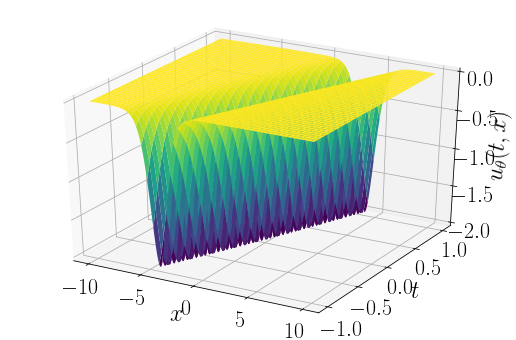

In [ ]:
u_LBFGS = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_LBFGS)

Solusi SGD

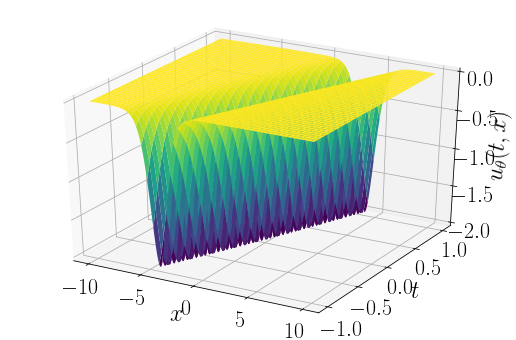

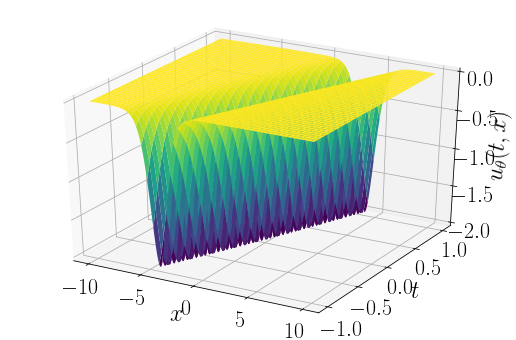

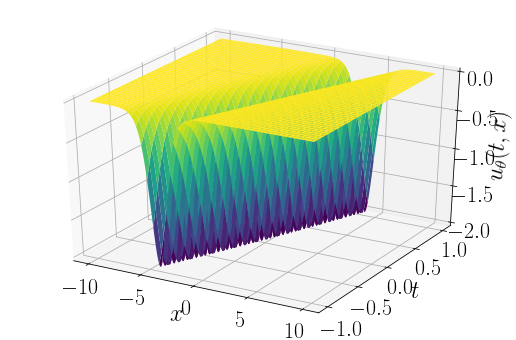

In [ ]:
u_SGD_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_exp)
u_SGD_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_pw)
u_SGD_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_comb)

Solusi Adam

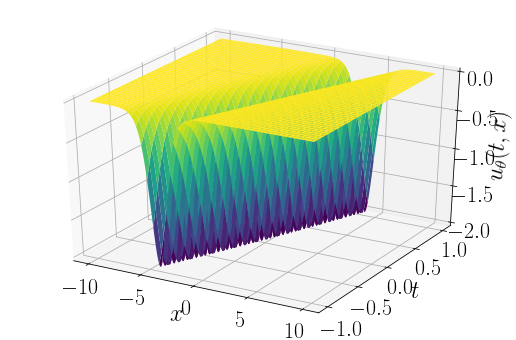

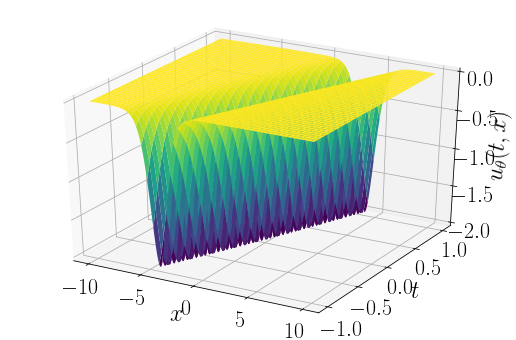

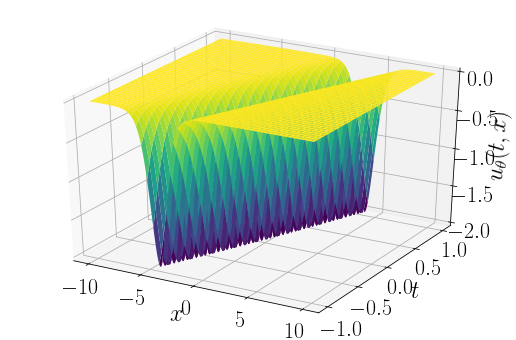

In [ ]:
u_Adam_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_exp)
u_Adam_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_pw)
u_Adam_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_comb)

### *Export Trained* Model

In [ ]:
path = dir + "/model weights/kdv_eqn_fwd"

model_LBFGS.save_weights(path+"/model_LBFGS.h5", 'h5')
model_SGD_exp.save_weights(path+"/model_SGD_exp.h5", 'h5')
model_SGD_pw.save_weights(path+"/model_SGD_pw.h5", 'h5')
model_SGD_comb.save_weights(path+"/model_SGD_comb.h5", 'h5')
model_Adam_exp.save_weights(path+"/model_Adam_exp.h5", 'h5')
model_Adam_pw.save_weights(path+"/model_Adam_pw.h5", 'h5')
model_Adam_comb.save_weights(path+"/model_Adam_comb.h5", 'h5')

In [ ]:
np.savetxt(path+"/loss/hist_LBFGS.txt", solver_LBFGS.hist)
np.savetxt(path+"/loss/hist_SGD_exp.txt", solver_SGD_exp.hist)
np.savetxt(path+"/loss/hist_SGD_pw.txt", solver_SGD_pw.hist)
np.savetxt(path+"/loss/hist_SGD_comb.txt", solver_SGD_comb.hist)
np.savetxt(path+"/loss/hist_Adam_exp.txt", solver_Adam_exp.hist)
np.savetxt(path+"/loss/hist_Adam_pw.txt", solver_Adam_pw.hist)
np.savetxt(path+"/loss/hist_Adam_comb.txt", solver_Adam_comb.hist)

### *Import Trained* Model

In [ ]:
path = dir + "/model weights/kdv_eqn_fwd"
model_LBFGS.load_weights(path+"/model_LBFGS.h5")
model_SGD_exp.load_weights(path+"/model_SGD_exp.h5")
model_SGD_pw.load_weights(path+"/model_SGD_pw.h5")
model_SGD_comb.load_weights(path+"/model_SGD_comb.h5")
model_Adam_exp.load_weights(path+"/model_Adam_exp.h5")
model_Adam_pw.load_weights(path+"/model_Adam_pw.h5")
model_Adam_comb.load_weights(path+"/model_Adam_comb.h5")

hist_LBFGS = np.loadtxt(path+"/loss/hist_LBFGS.txt")
hist_SGD_exp = np.loadtxt(path+"/loss/hist_SGD_exp.txt")
hist_SGD_pw = np.loadtxt(path+"/loss/hist_SGD_pw.txt")
hist_SGD_comb = np.loadtxt(path+"/loss/hist_SGD_comb.txt")
hist_Adam_exp = np.loadtxt(path+"/loss/hist_Adam_exp.txt")
hist_Adam_pw = np.loadtxt(path+"/loss/hist_Adam_pw.txt")
hist_Adam_comb = np.loadtxt(path+"/loss/hist_Adam_comb.txt")

## Pengembangan 5 Buah Model dengan Masing-Masing *Optimizer*

In [ ]:
n_models = 5
arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}

In [ ]:
# Set up model architecture & 
# initialize weights to be copied to other models

models = [None] * n_models

for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.PINN_NeuralNet(lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

In [ ]:
timeout = 100
start_from = 1

path = dir + "/model weights/kdv_eqn_fwd"
models_LBFGS = [None]*(start_from-1)
models_SGD_exp = [None]*(start_from-1)
models_SGD_pw = [None]*(start_from-1)
models_SGD_comb = [None]*(start_from-1)
models_Adam_exp = [None]*(start_from-1)
models_Adam_pw = [None]*(start_from-1)
models_Adam_comb = [None]*(start_from-1)
hists_LBFGS = [None]*(start_from-1)
hists_SGD_exp = [None]*(start_from-1)
hists_SGD_pw = [None]*(start_from-1)
hists_SGD_comb = [None]*(start_from-1)
hists_Adam_exp = [None]*(start_from-1)
hists_Adam_pw = [None]*(start_from-1)
hists_Adam_comb = [None]*(start_from-1)



for i in range(start_from-1, n_models):
  print('{:s}\nIteration: {:d}\n{:s}'.format(50*'-',i+1,50*'-'))

  tf.random.set_seed(i)
  models_LBFGS.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))

  models_LBFGS[i].build(input_shape=(None,2))
  models_SGD_exp[i].build(input_shape=(None,2))
  models_SGD_pw[i].build(input_shape=(None,2))
  models_SGD_comb[i].build(input_shape=(None,2))
  models_Adam_exp[i].build(input_shape=(None,2))
  models_Adam_pw[i].build(input_shape=(None,2))
  models_Adam_comb[i].build(input_shape=(None,2))

  # Copy weights from the previous model instance to make every iteration comparable  
  models_LBFGS[i].set_weights(models[i].get_weights())
  models_SGD_exp[i].set_weights(models[i].get_weights())
  models_SGD_pw[i].set_weights(models[i].get_weights())
  models_SGD_comb[i].set_weights(models[i].get_weights())
  models_Adam_exp[i].set_weights(models[i].get_weights())
  models_Adam_pw[i].set_weights(models[i].get_weights())
  models_Adam_comb[i].set_weights(models[i].get_weights())

  # Prepare optimizers
  optim_SGD_exp = tf.keras.optimizers.SGD(learning_rate=lr_exp)
  optim_SGD_pw = tf.keras.optimizers.SGD(learning_rate=lr_pw)
  optim_SGD_comb = tf.keras.optimizers.SGD(learning_rate=lr_comb)
  optim_Adam_exp = tf.keras.optimizers.Adam(learning_rate=lr_exp)
  optim_Adam_pw = tf.keras.optimizers.Adam(learning_rate=lr_pw)
  optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb) 

  # Initialize solvers
  solver_LBFGS = pinn.PINN_PDESolver(models_LBFGS[i], X_r, fun_r, get_r)
  solver_SGD_exp = pinn.PINN_PDESolver(models_SGD_exp[i], X_r, fun_r, get_r)
  solver_SGD_pw = pinn.PINN_PDESolver(models_SGD_pw[i], X_r, fun_r, get_r)
  solver_SGD_comb = pinn.PINN_PDESolver(models_SGD_comb[i], X_r, fun_r, get_r)
  solver_Adam_exp = pinn.PINN_PDESolver(models_Adam_exp[i], X_r, fun_r, get_r)
  solver_Adam_pw = pinn.PINN_PDESolver(models_Adam_pw[i], X_r, fun_r, get_r)
  solver_Adam_comb = pinn.PINN_PDESolver(models_Adam_comb[i], X_r, fun_r, get_r)

  # Train models
  print('\n\nL-BFGS\n')
  solver_LBFGS.solve_with_ScipyOptimizer(X_data, u_data,
                                        timeout=timeout,
                                        method='L-BFGS-B')
  print('\n\nSGD - Exponential Decay\n')
  solver_SGD_exp.solve_with_TFoptimizer(optim_SGD_exp, X_data, u_data, timeout=timeout)
  print('\n\nSGD - Piecewise Constant Decay\n')
  solver_SGD_pw.solve_with_TFoptimizer(optim_SGD_pw, X_data, u_data, timeout=timeout)
  print('\n\nSGD - Combined Learning Rate\n')
  solver_SGD_comb.solve_with_TFoptimizer(optim_SGD_comb, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Exponential Decay\n')
  solver_Adam_exp.solve_with_TFoptimizer(optim_Adam_exp, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Piecewise Constant Decay\n')
  solver_Adam_pw.solve_with_TFoptimizer(optim_Adam_pw, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Combined Learning Rate\n')
  solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, timeout=timeout)
  
  # Store evolution of lambdas and hists
  hists_LBFGS.append(solver_LBFGS.hist)
  hists_SGD_exp.append(solver_SGD_exp.hist)
  hists_SGD_pw.append(solver_SGD_pw.hist)
  hists_SGD_comb.append(solver_SGD_comb.hist)
  hists_Adam_exp.append(solver_Adam_exp.hist)
  hists_Adam_pw.append(solver_Adam_pw.hist)
  hists_Adam_comb.append(solver_Adam_comb.hist)

  print('\n\n\n')    

  # Export Model Weights and Losses
  models_LBFGS[i].save_weights(path+"_"+str(i)+"/model_LBFGS.h5", 'h5')
  models_SGD_exp[i].save_weights(path+"_"+str(i)+"/model_SGD_exp.h5", 'h5')
  models_SGD_pw[i].save_weights(path+"_"+str(i)+"/model_SGD_pw.h5", 'h5')
  models_SGD_comb[i].save_weights(path+"_"+str(i)+"/model_SGD_comb.h5", 'h5')
  models_Adam_exp[i].save_weights(path+"_"+str(i)+"/model_Adam_exp.h5", 'h5')
  models_Adam_pw[i].save_weights(path+"_"+str(i)+"/model_Adam_pw.h5", 'h5')
  models_Adam_comb[i].save_weights(path+"_"+str(i)+"/model_Adam_comb.h5", 'h5')

  np.savetxt(path+"_"+str(i)+"/loss/hist_LBFGS.txt", hists_LBFGS[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_exp.txt", hists_SGD_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_pw.txt", hists_SGD_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_comb.txt", hists_SGD_comb[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_exp.txt", hists_Adam_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_pw.txt", hists_Adam_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_comb.txt", hists_Adam_comb[i])

--------------------------------------------------
Iteration: 1
--------------------------------------------------


L-BFGS

It 00000: l_u = 2.57736797e-01 l_f = 2.58032046e-03 loss = 2.60317117e-01
It 00050: l_u = 1.74216088e-03 l_f = 3.92065523e-03 loss = 5.66281611e-03
It 00100: l_u = 1.16716372e-04 l_f = 5.68808289e-04 loss = 6.85524661e-04
It 00150: l_u = 1.40598277e-05 l_f = 1.53533838e-04 loss = 1.67593666e-04
It 00200: l_u = 2.87753937e-06 l_f = 4.77478789e-05 loss = 5.06254182e-05
It 00250: l_u = 3.14202407e-06 l_f = 3.26201807e-05 loss = 3.57622048e-05
It 00300: l_u = 1.78369919e-06 l_f = 2.14558804e-05 loss = 2.32395796e-05
It 00350: l_u = 9.09855771e-07 l_f = 1.40689399e-05 loss = 1.49787957e-05
It 00400: l_u = 8.50794095e-07 l_f = 1.08919385e-05 loss = 1.17427326e-05
It 00450: l_u = 4.25136932e-07 l_f = 8.68400366e-06 loss = 9.10914059e-06
It 00500: l_u = 2.18433343e-07 l_f = 6.75483034e-06 loss = 6.97326368e-06
Timeout is reached. Time elapsed: 100.01878094673157


SGD - 

### *Export* Model
*Export* hasil *training* model agar bisa digunakan di luar *training runtime*. *Export* meliputi parameter model dan riwayat *loss* yang diperoleh.

*Export* bobot dan bias yang diperoleh pada *training*.

In [ ]:
path = dir + "/model weights/kdv_eqn_fwd"

for i in range(n_models):  
	models_LBFGS[i].save_weights(path+"_"+str(i)+"/model_LBFGS.h5", 'h5')
	models_SGD_exp[i].save_weights(path+"_"+str(i)+"/model_SGD_exp.h5", 'h5')
	models_SGD_pw[i].save_weights(path+"_"+str(i)+"/model_SGD_pw.h5", 'h5')
	models_SGD_comb[i].save_weights(path+"_"+str(i)+"/model_SGD_comb.h5", 'h5')
	models_Adam_exp[i].save_weights(path+"_"+str(i)+"/model_Adam_exp.h5", 'h5')
	models_Adam_pw[i].save_weights(path+"_"+str(i)+"/model_Adam_pw.h5", 'h5')
	models_Adam_comb[i].save_weights(path+"_"+str(i)+"/model_Adam_comb.h5", 'h5')

*Export* perkembangan *loss* pada *training* dalam bentuk `hist`.

In [ ]:
for i in range(n_models):
  np.savetxt(path+"_"+str(i)+"/loss/hist_LBFGS.txt", hists_LBFGS[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_exp.txt", hists_SGD_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_pw.txt", hists_SGD_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_comb.txt", hists_SGD_comb[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_exp.txt", hists_Adam_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_pw.txt", hists_Adam_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_comb.txt", hists_Adam_comb[i])

### *Import* Model
*Import* model beserta *loss* dari 5 percobaan pemodelan yang telah dilakukan. Langkah ini diperlukan jika penggunaan model di luar *training runtime*.

In [ ]:
n_models = 5
timeout = 100
path = dir + "/model weights/kdv_eqn_fwd"

arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}
models_LBFGS = []
models_SGD_exp = []
models_SGD_pw = []
models_SGD_comb = []
models_Adam_exp = []
models_Adam_pw = []
models_Adam_comb = []
hists_LBFGS = []
hists_SGD_exp = []
hists_SGD_pw = []
hists_SGD_comb = []
hists_Adam_exp = []
hists_Adam_pw = []
hists_Adam_comb = []


for i in range(n_models):
  models_LBFGS.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))

  models_LBFGS[i].build(input_shape=(None,2))
  models_SGD_exp[i].build(input_shape=(None,2))
  models_SGD_pw[i].build(input_shape=(None,2))
  models_SGD_comb[i].build(input_shape=(None,2))
  models_Adam_exp[i].build(input_shape=(None,2))
  models_Adam_pw[i].build(input_shape=(None,2))
  models_Adam_comb[i].build(input_shape=(None,2))

  models_LBFGS[i].load_weights(path+"_"+str(i)+"/model_LBFGS.h5")
  models_SGD_exp[i].load_weights(path+"_"+str(i)+"/model_SGD_exp.h5")
  models_SGD_pw[i].load_weights(path+"_"+str(i)+"/model_SGD_pw.h5")
  models_SGD_comb[i].load_weights(path+"_"+str(i)+"/model_SGD_comb.h5")
  models_Adam_exp[i].load_weights(path+"_"+str(i)+"/model_Adam_exp.h5")
  models_Adam_pw[i].load_weights(path+"_"+str(i)+"/model_Adam_pw.h5")
  models_Adam_comb[i].load_weights(path+"_"+str(i)+"/model_Adam_comb.h5")

  hists_LBFGS.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_LBFGS.txt"))
  hists_SGD_exp.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_exp.txt"))
  hists_SGD_pw.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_pw.txt"))
  hists_SGD_comb.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_comb.txt"))
  hists_Adam_exp.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_exp.txt"))
  hists_Adam_pw.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_pw.txt"))
  hists_Adam_comb.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_comb.txt"))

## 4. Prediksi Solusi dan Evaluasi Kinerja Model

### Grafik Riwayat *Loss* pada tahap *Learning*

NameError: ignored

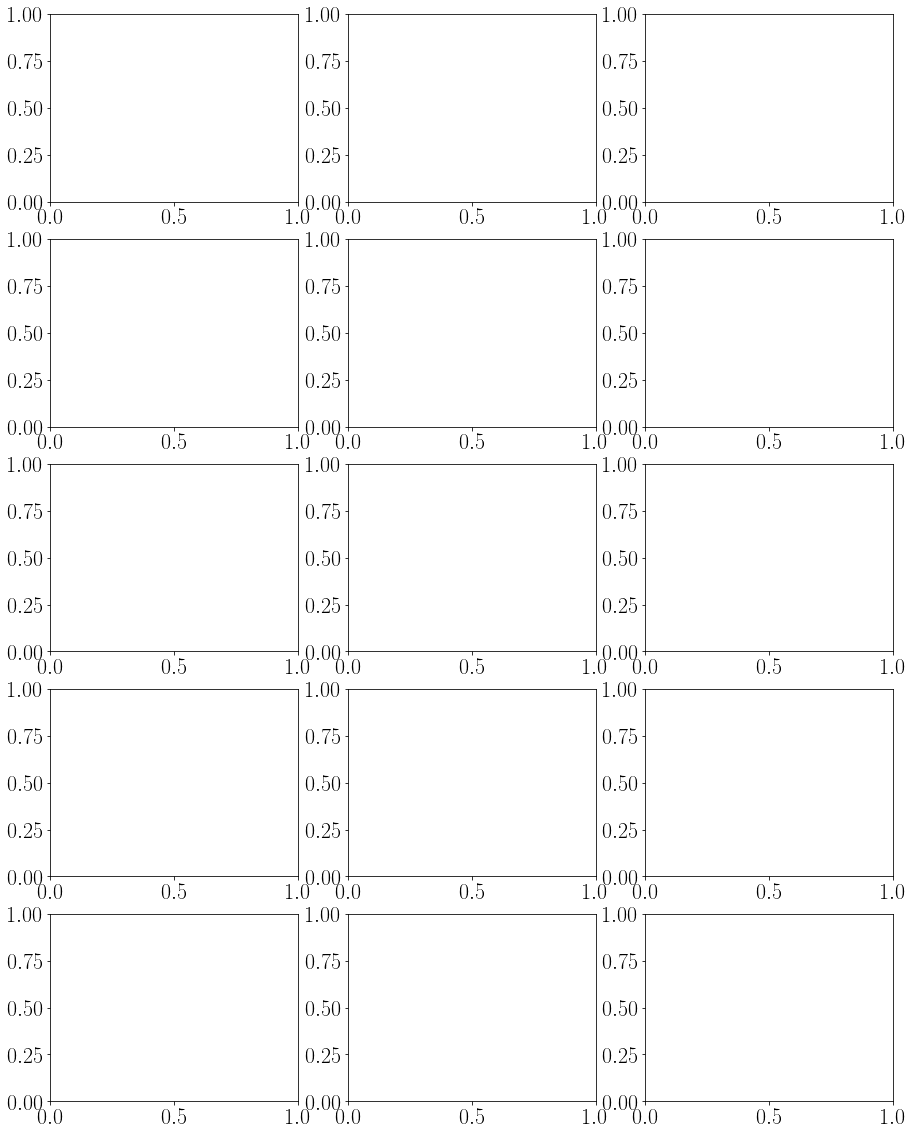

In [ ]:
fig, axes = plt.subplots(nrows=n_models, ncols=3, figsize=(15.1,20))

for i in range(n_models):
  axes[i,0].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_SGD_exp[i])), hists_SGD_exp[i])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_Adam_exp[i])), hists_Adam_exp[i])
  
  axes[i,1].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_SGD_pw[i])), hists_SGD_pw[i])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_Adam_pw[i])), hists_Adam_pw[i])

  axes[i,2].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_SGD_comb[i])), hists_SGD_comb[i])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_Adam_comb[i])), hists_Adam_comb[i])


cols = ['lrExp', 'lrPw', 'lrComb']
rows = ['Attempt {}'.format(row) for row in range(1, n_models+1)]

pad = 20 # in points

for ax_row in axes:
  for ax in ax_row:    
    ax.set_xlabel('training time (seconds)')
    ax.set_ylabel('loss')
    ax.set_xlim([50,100])
    ax.set_ylim([0,1e-4])
    ax.ticklabel_format(axis='y', scilimits=(0,0))

for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1.05), xytext=(0, pad),
              xycoords='axes fraction', textcoords='offset points',
              size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
  ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
              xycoords=ax.yaxis.label, textcoords='offset points',
              size='large', ha='right', va='center')

# fig.suptitle('$Riwayat \it{Loss}$ pada Lima \nModel yang Dikembangkan', y=1.05, fontsize=25)

# fig.subplots_adjust(left=0.01, top=0.6)
fig.tight_layout()
fig.legend(['L-BFGS', 'SGD', 'Adam'], loc='lower center', bbox_to_anchor=(0.5, -0.015), ncol=3, frameon=True)

# plt.savefig('kdv_eqn_fwd_hists.pdf', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

### Hasil Prediksi Model

In [ ]:
Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

In [ ]:
print("Koordinat x, 5 elemen pertama:", list(xspace[:5]))
print("Koordinat x, 5 elemen terakhir:", list(xspace[-5:]), "\n")

print("Koordinat t, 5 elemen pertama:", list(tspace[:5]))
print("Koordinat t, 5 elemen terakhir:", list(tspace[-5:]), "\n")

Koordinat x, 5 elemen pertama: [-10.0, -9.98, -9.96, -9.94, -9.92]
Koordinat x, 5 elemen terakhir: [9.920000000000002, 9.940000000000001, 9.96, 9.98, 10.0] 

Koordinat t, 5 elemen pertama: [-1.0, -0.998, -0.996, -0.994, -0.992]
Koordinat t, 5 elemen terakhir: [0.992, 0.994, 0.996, 0.998, 1.0] 



#### Solusi Eksplisit

Solusi analitik untuk persamaan panas.

In [ ]:
path = dir + "/Data/"

# Solusi Eksplisit
# u_star = np.empty([len(xspace), len(tspace)])
# i = 0
# for x_i in xspace:
#   j = 0
#   for t_i in tspace:    
#     u_star[i][j] = u_expl(t_i, x_i); j += 1
#   i += 1

# np.savetxt(path + "u_star_kdv_1.csv", u_star)

u_star = np.loadtxt(path + "u_star_kdv_1.csv")

In [ ]:
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u_star, cmap='viridis', facecolor=(0,0,0,0));
# ax.view_init(35,35)
ax.set_xlabel('$x$', labelpad=20)
ax.set_ylabel('$t$', labelpad=20)
ax.set_zlabel('$v(x,t)$', labelpad=30)
ax.invert_zaxis()
# ax.set_title('Solusi analitik untuk persamaan KdV.');

ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)
ax.tick_params(axis='z', pad=15)
ax.set_yticks(np.arange(-1, 1+0.5, 0.5))
ax.set_zticks(np.arange(-2, 0+0.5, 0.5))

# from matplotlib.ticker import MaxNLocator
# plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
# plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.tight_layout()
# plt.savefig('kdv_eqn_fwd_exact.pdf', bbox_inches='tight', dpi=600, facecolor='none')
plt.show()

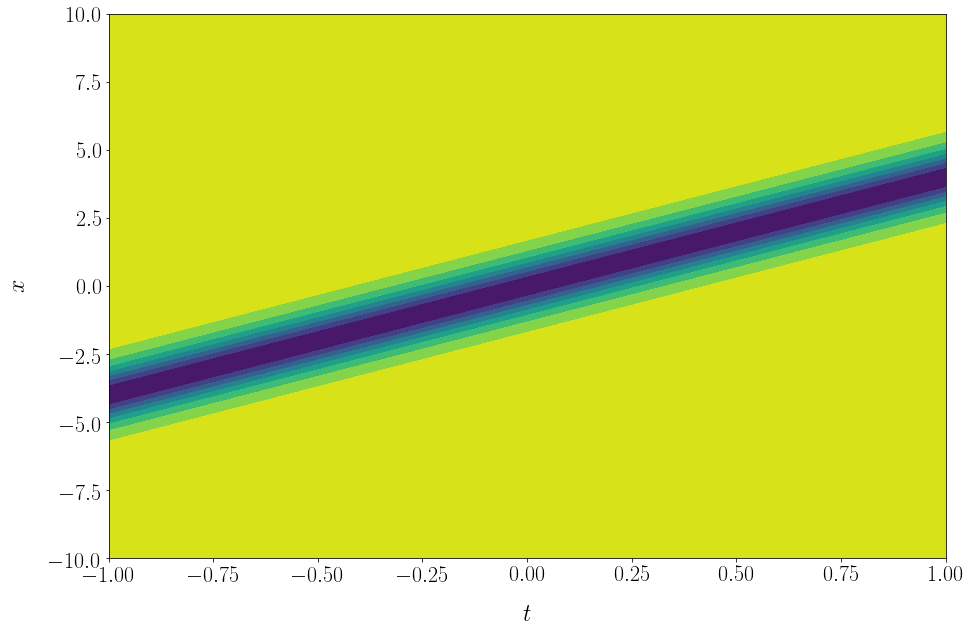

In [ ]:
# Contour plot of solution u(t,x)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.contourf(T, X, u_star, cmap='viridis');
ax.set_xlabel('$t$', labelpad=20)
ax.set_ylabel('$x$', labelpad=20)
# ax.set_title('Solusi analitik untuk persamaan KdV.');

# plt.savefig('kdv_eqn_fwd_exact_contour.pdf', bbox_inches='tight', dpi=600, facecolor='none')
plt.show()

#### Evaluasi Galat Model

Prediksi solusi dengan model-model yang telah dibuat.

In [ ]:
preds_LBFGS = []
preds_SGD_exp = []
preds_SGD_pw = []
preds_SGD_comb = []
preds_Adam_exp = []
preds_Adam_pw = []
preds_Adam_comb = []

for i in range(n_models):
  preds_LBFGS.append(pinn.predict_solution(models_LBFGS[i], Nt, Nx))
  preds_SGD_exp.append(pinn.predict_solution(models_SGD_exp[i], Nt, Nx))
  preds_SGD_pw.append(pinn.predict_solution(models_SGD_pw[i], Nt, Nx))
  preds_SGD_comb.append(pinn.predict_solution(models_SGD_comb[i], Nt, Nx))
  preds_Adam_exp.append(pinn.predict_solution(models_Adam_exp[i], Nt, Nx))
  preds_Adam_pw.append(pinn.predict_solution(models_Adam_pw[i], Nt, Nx))
  preds_Adam_comb.append(pinn.predict_solution(models_Adam_comb[i], Nt, Nx))

In [ ]:
df = pd.DataFrame(columns = ['L-BFGS' , 
                             'SGD (exp)', 'SGD (pw)', 'SGD (comb)',  
                             'Adam (exp)', 'Adam (pw)', 'Adam (comb)'])

for i in range(n_models):
  df.loc['Attempt '+str(i+1)] = [pinn.evaluate_solution(preds_LBFGS[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_exp[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_pw[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_comb[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_exp[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_pw[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_comb[i], u_star)]

df

L-BFGS   SGD (exp)    SGD (pw)  SGD (comb)  Adam (exp)  \
Attempt 1  107.683491  107.543716  107.535792  107.545273  107.668776   
Attempt 2  107.656458  106.737253  106.848711  106.760108  107.677099   
Attempt 3  107.665364  107.338182  107.369620  107.342580  107.679558   
Attempt 4  107.680598  107.492829  107.498855  107.495407  107.675563   
Attempt 5  107.655772  107.298576  107.198796  107.272609  107.670361   

            Adam (pw)  Adam (comb)  
Attempt 1  107.677565   107.667946  
Attempt 2  107.672741   107.676960  
Attempt 3  107.684548   107.680598  
Attempt 4  107.679461   107.675686  
Attempt 5  107.672416   107.668972

In [ ]:
df.idxmin(axis=1)

Attempt 1     SGD (pw)
Attempt 2    SGD (exp)
Attempt 3    SGD (exp)
Attempt 4    SGD (exp)
Attempt 5     SGD (pw)
dtype: object

In [ ]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

L-BFGS         107.668337
SGD (exp)      107.282111
SGD (pw)       107.290355
SGD (comb)     107.283196
Adam (exp)     107.674272
Adam (pw)      107.677346
Adam (comb)    107.674033
dtype: float64


In [ ]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrrr}
\hline
           &   L-BFGS &   SGD (exp) &   SGD (pw) &   SGD (comb) &   Adam (exp) &   Adam (pw) &   Adam (comb) \\
\hline
 Attempt 1 & 107.6835 &    107.5437 &   107.5358 &     107.5453 &     107.6688 &    107.6776 &      107.6679 \\
 Attempt 2 & 107.6565 &    106.7373 &   106.8487 &     106.7601 &     107.6771 &    107.6727 &      107.6770 \\
 Attempt 3 & 107.6654 &    107.3382 &   107.3696 &     107.3426 &     107.6796 &    107.6845 &      107.6806 \\
 Attempt 4 & 107.6806 &    107.4928 &   107.4989 &     107.4954 &     107.6756 &    107.6795 &      107.6757 \\
 Attempt 5 & 107.6558 &    107.2986 &   107.1988 &     107.2726 &     107.6704 &    107.6724 &      107.6690 \\
 Average   & 107.6683 &    107.2821 &   107.2904 &     107.2832 &     107.6743 &    107.6773 &      107.6740 \\
\hline
\end{tabular}


#### Analisis Hasil Prediksi

In [ ]:
u_PINN = preds_Adam_exp[1]
def tau(t):
  return int((Nt*(t - lb[0])/(ub[0] - lb[0])).numpy())

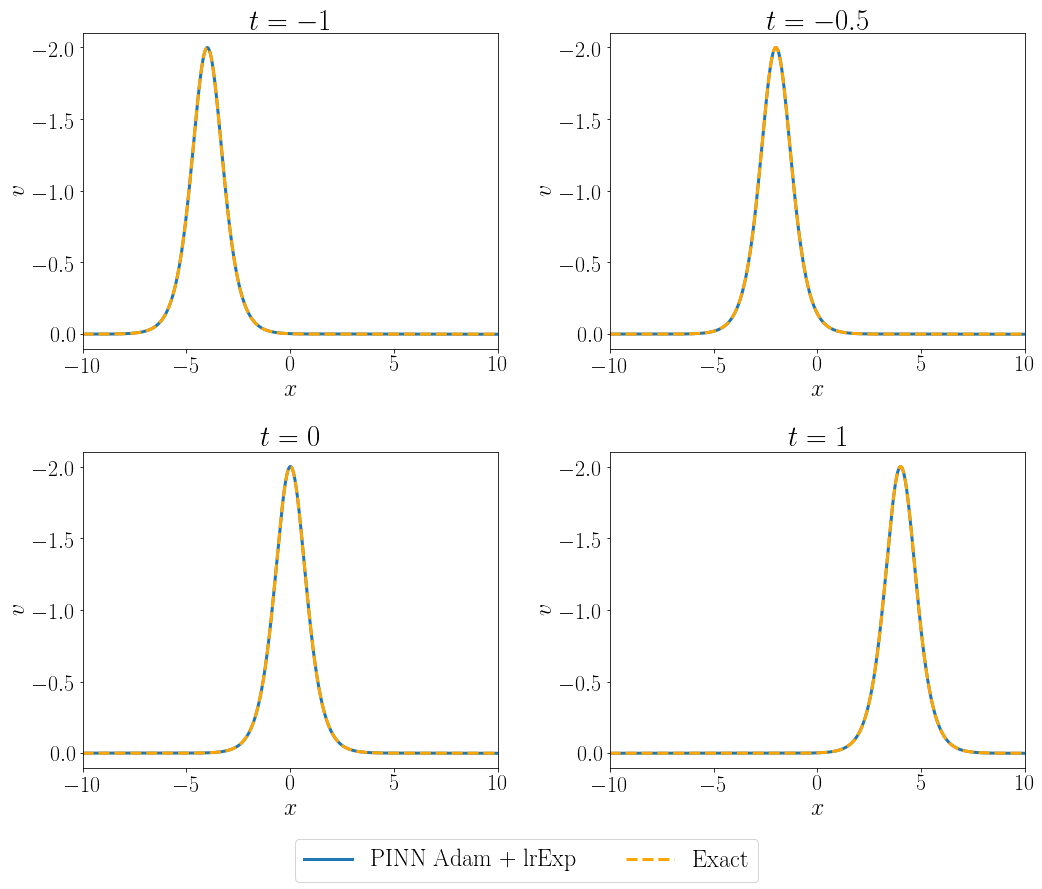

In [ ]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

t1 = -1
ax1.plot(xspace,u_PINN[:,tau(t1)], lw=3)
ax1.plot(xspace,u_star[:,tau(t1)], ls="--", lw=3, c='orange')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$v$')
ax1.set_title('$t=-1$')
ax1.invert_yaxis()
ax1.set_xlim([-10,10])

t2 = -0.5
ax2.plot(xspace,u_PINN[:,tau(t2)], lw=3)
ax2.plot(xspace,u_star[:,tau(t2)], ls="--", lw=3, c='orange')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$v$')
ax2.set_title('$t=-0.5$')
ax2.invert_yaxis()
ax2.set_xlim([-10,10])

t3 = 0
ax3.plot(xspace,u_PINN[:,tau(t3)], lw=3)
ax3.plot(xspace,u_star[:,tau(t3)], ls="--", lw=3, c='orange')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$v$')
ax3.set_title('$t=0$')
ax3.invert_yaxis()
ax3.set_xlim([-10,10])

t4 = 1
ax4.plot(xspace,u_PINN[:,tau(t4)], lw=3)
ax4.plot(xspace,u_star[:,tau(t4)], ls="--", lw=3, c='orange')
ax4.set_xlabel('$x$')
ax4.set_ylabel('$v$')
ax4.set_title('$t=1$')
ax4.invert_yaxis()
ax4.set_xlim([-10,10])

plt.tight_layout()
plt.legend(['PINN Adam + lrExp', 'Exact'], 
           loc='lower center', bbox_to_anchor=(-0.2, -0.4), ncol=3, frameon=True)

# plt.savefig('kdv_eqn_sol.pdf', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

In [ ]:
plt.figure(figsize=(7.5, 6))
plt.plot(tspace, pinn.evaluate_solution_log_time(u_PINN, u_star), c='green')
plt.xlabel('$t$')
plt.ylabel('$\log(\\frac{1}{1001}\sum_{i=0}^{1000}{|u_i-\hat{u}_i|})$')
plt.xlim([-1.0,1.0])
plt.ylim([-9.00,-7.00])

# plt.savefig('kdv_eqn_sol_error.pdf', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

##### Prediksi pada t=50

In [27]:
Nt = 5000; Nx = 5000

# Set boundary
tmin = -50.
tmax = 50.
xmin = -250.
xmax = 250.

lb_new = tf.constant([tmin, xmin], dtype=DTYPE)
ub_new = tf.constant([tmax, xmax], dtype=DTYPE)
tspace = np.linspace(lb_new[0], ub_new[0], Nt+1)
xspace = np.linspace(lb_new[1], ub_new[1], Nx+1)
T, X = np.meshgrid(tspace, xspace)

def tau(t):
  return int((Nt*(t - lb_new[0])/(ub_new[0] - lb_new[0])).numpy())

In [19]:
# Solusi Eksplisit
u_star = np.empty([len(xspace), len(tspace)])
i = 0
for x_i in xspace:
  j = 0
  for t_i in tspace:    
    u_star[i][j] = u_expl(t_i, x_i); j += 1
  i += 1

# np.savetxt(path + "u_star_kdv_1.csv", u_star)

# u_star = np.loadtxt(path + "u_star_kdv_1.csv")

<ipython-input-5-6ac951483102>:4: RuntimeWarning: overflow encountered in double_scalars
  return -2 * 1/(np.cosh(x-4*t))**2


In [69]:
# np.savetxt("u_star_kdv_extended.csv", u_star)
# import os
# size_bytes = os.stat("u_star_kdv_extended.csv").st_size

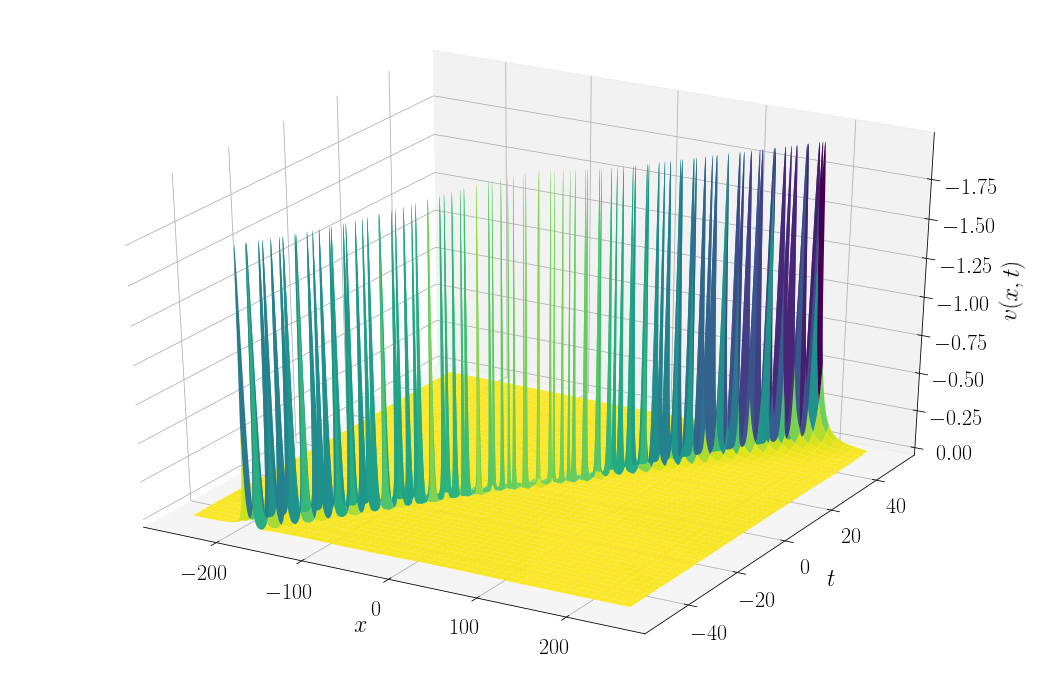

In [22]:
best_model = models_Adam_exp[1]

Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = best_model(tf.cast(Xgrid,DTYPE))
# Reshape upred
u_PINN = upred.numpy().reshape(Nt+1,Nx+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u_PINN, cmap='viridis', facecolor=(0,0,0,0));
# ax.view_init(35,35)
ax.set_xlabel('$x$', labelpad=20)
ax.set_ylabel('$t$', labelpad=20)
ax.set_zlabel('$v(x,t)$', labelpad=30)
ax.invert_zaxis()
# ax.set_title('Solusi analitik untuk persamaan KdV.');

ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)
ax.tick_params(axis='z', pad=15)
# ax.set_yticks(np.arange(-1, 1+0.5, 0.5))
# ax.set_zticks(np.arange(-2, 0+0.5, 0.5))

# from matplotlib.ticker import MaxNLocator
# plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
# plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.tight_layout()
# plt.savefig('kdv_eqn_fwd_exact.pdf', bbox_inches='tight', dpi=600, facecolor='none')
plt.show()

In [60]:
pinn.evaluate_solution(u_PINN, u_star)

407.98548245118786

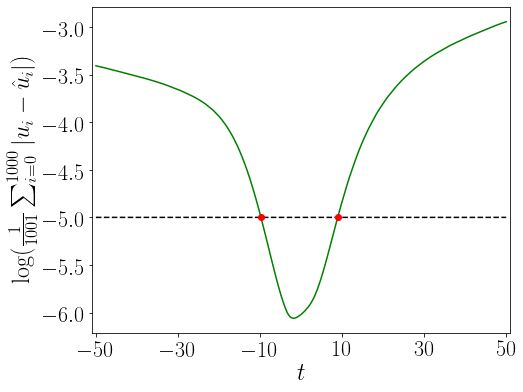

In [58]:
plt.figure(figsize=(7.5, 6))
f = np.full((len(tspace),),-5.0)

error = pinn.evaluate_solution_log_time(u_PINN, u_star)
plt.plot(tspace, error, c='green')
plt.plot(tspace, f, '--', c='black')

idx = np.argwhere(np.diff(np.sign(f - error))).flatten()
plt.plot(tspace[idx], f[idx], 'ro')

plt.xlabel('$t$')
plt.ylabel('$\log(\\frac{1}{1001}\sum_{i=0}^{1000}{|u_i-\hat{u}_i|})$')
plt.xlim([-51.0,51.0])
plt.xticks(np.arange(-50, 50+1, 20))
# plt.ylim([-9.00,-7.00])

# plt.savefig('kdv_eqn_sol_error_extended.pdf', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

In [56]:
def inverse_tau(idx):
  return (idx * (ub_new[0] - lb_new[0]) / Nt + lb_new[0]).numpy()

t_best = inverse_tau(idx)
print(t_best)

[-9.779999  8.919998]


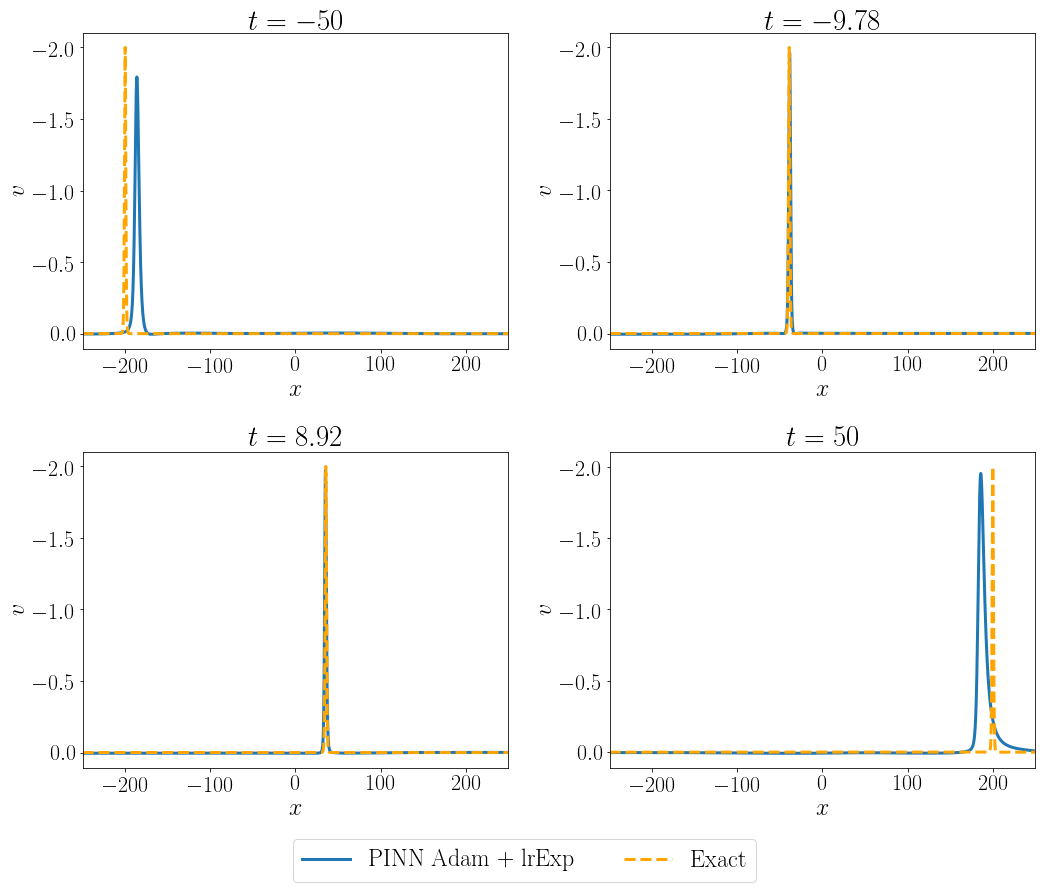

In [59]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

t1 = -50
ax1.plot(xspace,u_PINN[:,tau(t1)], lw=3)
ax1.plot(xspace,u_star[:,tau(t1)], ls="--", lw=3, c='orange')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$v$')
ax1.set_title('$t=-50$')
ax1.invert_yaxis()
ax1.set_xlim([-250,250])

t2 = -9.78
ax2.plot(xspace,u_PINN[:,tau(t2)], lw=3)
ax2.plot(xspace,u_star[:,tau(t2)], ls="--", lw=3, c='orange')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$v$')
ax2.set_title('$t=-9.78$')
ax2.invert_yaxis()
ax2.set_xlim([-250,250])

t3 = 8.92
ax3.plot(xspace,u_PINN[:,tau(t3)], lw=3)
ax3.plot(xspace,u_star[:,tau(t3)], ls="--", lw=3, c='orange')
ax3.set_xlabel('$x$')
ax3.set_ylabel('$v$')
ax3.set_title('$t=8.92$')
ax3.invert_yaxis()
ax3.set_xlim([-250,250])

t4 = 50
ax4.plot(xspace,u_PINN[:,tau(t4)], lw=3)
ax4.plot(xspace,u_star[:,tau(t4)], ls="--", lw=3, c='orange')
ax4.set_xlabel('$x$')
ax4.set_ylabel('$v$')
ax4.set_title('$t=50$')
ax4.invert_yaxis()
ax4.set_xlim([-250,250])

plt.tight_layout()
plt.legend(['PINN Adam + lrExp', 'Exact'], 
           loc='lower center', bbox_to_anchor=(-0.2, -0.4), ncol=3, frameon=True)

# plt.savefig('kdv_eqn_sol_extended.pdf', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

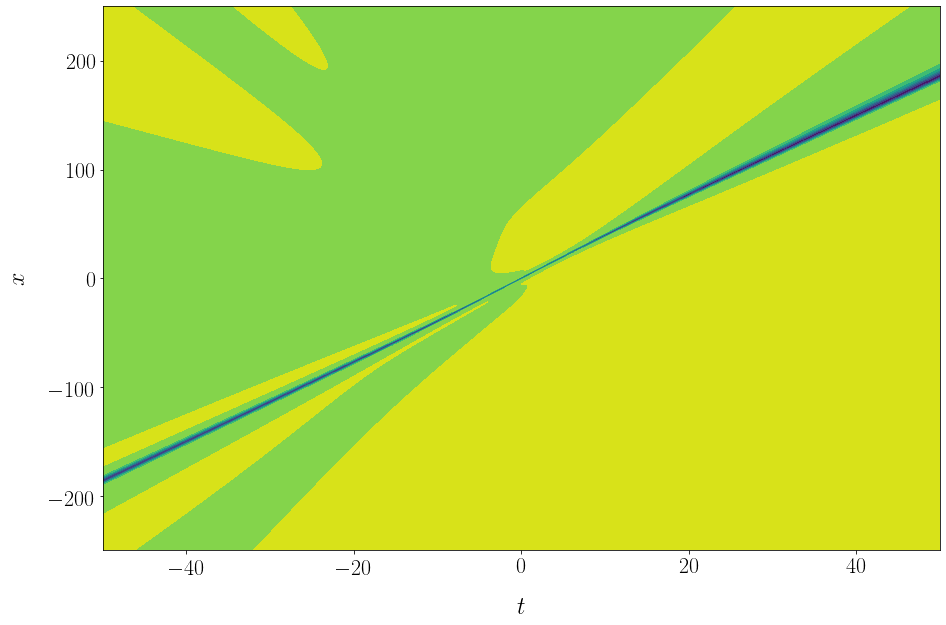

In [ ]:
# Contour plot of solution u(t,x)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.contourf(T, X, U, cmap='viridis');
ax.set_xlabel('$t$', labelpad=20)
ax.set_ylabel('$x$', labelpad=20)

# plt.savefig('kdv_eqn_fwd_pinn_ext_contour.pdf', bbox_inches='tight', dpi=600, facecolor='none')
plt.show()

#Masalah Invers

## 1. Persiapan Pemodelan

### Pembangkitan Data *Training* dan *Collocation Points* untuk Masalah Invers

In [ ]:
N_d = 500
noise = 0.0

plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:  
  # Draw points with measurements randomly
  t_d = tf.random.uniform((N_d,1), lb[0], ub[0], dtype=DTYPE)
  x_d = tf.random.uniform((N_d,1), lb[1], ub[1], dtype=DTYPE)
  X_d = tf.concat([t_d, x_d], axis=1)
  
  # Explicit analytical solution
  u_d = u_expl(t_d, x_d)
  u_d += noise * tf.random.normal(u_d.shape, dtype=DTYPE)

elif plot == False:
  X_d, u_d = pinn.generate_collocation_points(N_d, lb, ub, u_expl, noise=0)

X_param = [X_d]
u_param = [u_d]

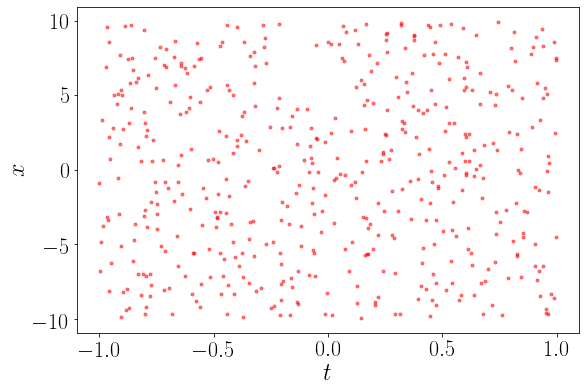

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_d, x_d, c='r', marker='.', alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('$x$')

# plt.title('(b) Visualisasi koordinat data $\it{training}$ dan $\it{collocation\;points}$ untuk masalah invers persamaan KdV.');
# plt.savefig('kdv_eqn_inv_train.pdf', bbox_inches='tight', dpi=600, facecolor='none')

plt.show()

### Persiapan Arsitektur PINN

Pada *hidden layer* pertama, terdapat $2 \times 20 = 40$ parameter bobot dan $20$ parameter bias. Pada *hidden layer* selanjutnya, terdapat $20 \times 20 = 400$ parameter bobot dan $20$ parameter bias dalam setiap *layer*. Di *output layer* yang terhubung *hidden layer* terakhir, terdapat $1 \times 20 = 20$ parameter bobot dan $20$ parameter bias. 

Maka, terdapat sejumlah
    \begin{align*}
        1 \times (40+20) + 1 \times (400+20) + 1 \times (20+20) = 520
    \end{align*}
    parameter yang dapat ditentukan dan diperbarui pada setiap *epoch* dalam PINN.

In [ ]:
arch = {'output_dim':1, 'num_hidden_layers':2, 'num_neurons_per_layer':20}
n_models = 5

In [ ]:
models = [None] * n_models

for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.PINN_IdentificationNet(initial_lambda=[0.0, 0.0], lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

### Persiapan Perhitungan *Loss Function*

In [ ]:
def get_r(t, x, model, fun_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape1:  
        
        tape1.watch(x)        
        with tf.GradientTape(persistent=True) as tape2:
          
          tape2.watch(x)
          with tf.GradientTape(persistent=True) as tape3:
          
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape3.watch(t)
            tape3.watch(x)
          
            # Determine residual 
            u = model(tf.stack([t[:,0], x[:,0]], axis=1))

          # Compute gradient u_x and u_t
          u_t = tape3.gradient(u, t)
          u_x = tape3.gradient(u, x)       
        
        u_xx = tape2.gradient(u_x, x)
    
    u_xxx = tape1.gradient(u_xx, x)

    del tape1
    del tape2
    del tape3

    return fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, model)
  
def fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, model):
    return u_t + model.lambd[0] * u * u_x + model.lambd[1] * u_xxx

In [ ]:
def get_r_param(t, x, model):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        # t, x = X_r[:, 0:1], X_r[:,1:2]
        
        tape.watch(x)
        with tf.GradientTape(persistent=True) as tape2:
          
          tape2.watch(x)
          with tf.GradientTape(persistent=True) as tape3:
            tape3.watch(t)
            tape3.watch(x)

            # Determine residual 
            u = model(tf.stack([t[:,0], x[:,0]], axis=1))
          
          u_t = tape3.gradient(u, t)
          u_x = tape3.gradient(u, x)

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives        
        u_xx = tape2.gradient(u_x, x)
            
    
    u_xxx = tape.gradient(u_xx, x)

    del tape
    del tape2
    del tape3

    with tf.GradientTape(persistent=True) as tape_lambd:
      tape_lambd.watch(model.lambd)
      r = u_t + model.lambd[0] * u * u_x + model.lambd[1] * u_xxx
      loss = tf.reduce_mean(tf.square(r))
    
    g = tape_lambd.gradient(loss, model.lambd)
    
    del tape_lambd    

    return loss, g

## 2. Persiapan *Optimizer*

Karena data yang digunakan lebih sedikit untuk kasus masalah invers, maka iterasi *optimizer* berbasis *gradient descent* akan menjadi lebih banyak. Maka, boundary untuk *learning rate* yang akan digunakan pada *Piecewise Constant Decay* harus lebih besar.

In [ ]:
# lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# # Choose the optimizer
# optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_pw)
# optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_pw)

# boundaries = [3000,7000]
# values = [1e-1,1e-2,1e-3]
lr_comb_param = {'boundaries': [3000,7000,14000],
                 'initial_learning_rate': 1e-1,
                 'decay_steps': 150,
                 'decay_rate': 0.9,
                 'values_steps': 2}
lr_comb = CombinedDecay(**lr_comb_param)
lr_comb.get_config()

{'initial_learning_rate': 0.1,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [3000, 7000, 14000],
 'values': [0.012157665459056936,
  0.006078832729528468,
  0.003039416364764234,
  0.001519708182382117],
 'values_steps': [2, 2, 2],
 'name': None}

## 3. *Training* Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [[0.0, 0.0], [1.0, -6.0], [10.0, 10.0]]
path = dir + "/model weights/kdv_eqn_inv"

old_timeout = timeout
models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models


for i in range(n_models):
  timeout = old_timeout
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    # Prepare models' architecture
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch)) 
    
    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_LBFGS[i][j].set_weights(models[i].get_weights())
    models_SGD[i][j].set_weights(models[i].get_weights())
    models_Adam[i][j].set_weights(models[i].get_weights())
    
    # Assigning initial lambda
    models_LBFGS[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_SGD[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_Adam[i][j].trainable_variables[-1].assign(initial_lambdas[j])

    # Prepare optimizer
    optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_comb)
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_LBFGS = pinn.PINN_IdentificationSolver(models_LBFGS[i][j], X_d, fun_r, get_r)
    solver_SGD = pinn.PINN_IdentificationSolver(models_SGD[i][j], X_d, fun_r, get_r)
    solver_Adam = pinn.PINN_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nL-BFGS\n')
    solver_LBFGS.solve_with_ScipyOptimizer(X_param, u_param,
                                          timeout=timeout,
                                          method='L-BFGS-B')
    print('\n\nSGD\n')
    solver_SGD.solve_with_TFoptimizer(optim_SGD, X_param, u_param, timeout=timeout)
    print('\n\nAdam\n')
    solver_Adam.solve_with_TFoptimizer(optim_Adam, X_param, u_param, timeout=timeout)
    
    # Store evolution of lambdas and hists
    hists_LBFGS[i].append(np.array([models_LBFGS[i][j].lambd_list, solver_LBFGS.hist]))
    hists_SGD[i].append(np.array([models_SGD[i][j].lambd_list, solver_SGD.hist]))
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_Adam.hist]))

    hists_LBFGS[i][j] = np.column_stack((np.stack(hists_LBFGS[i][j][0], axis=0), hists_LBFGS[i][j][1]))
    hists_SGD[i][j] = np.column_stack((np.stack(hists_SGD[i][j][0], axis=0), hists_SGD[i][j][1]))
    hists_Adam[i][j] = np.column_stack((np.stack(hists_Adam[i][j][0], axis=0), hists_Adam[i][j][1]))

    print('\n\n\n')

--------------------------------------------------
Iteration: 1 Initial lambda: [0.0, 0.0]
--------------------------------------------------


L-BFGS

It 00000: loss = 2.58083671e-01 lambda = [-3.4764460e-06 -1.1897985e-06]
It 00050: loss = 1.52042001e-01 lambda = [-0.6725802 -0.4526452]
It 00100: loss = 8.94438773e-02 lambda = [-4.1198273  0.1602027]
It 00150: loss = 1.17732007e-02 lambda = [-5.2874403   0.59955394]
It 00200: loss = 3.74858826e-03 lambda = [-5.220403   0.7202463]
It 00250: loss = 1.46021089e-03 lambda = [-5.4984336   0.78801507]
It 00300: loss = 4.27827676e-04 lambda = [-5.7718287   0.92154473]
It 00350: loss = 2.19210182e-04 lambda = [-5.8913536  0.9681635]
It 00400: loss = 1.39220443e-04 lambda = [-5.966344    0.98368007]
It 00450: loss = 8.74988255e-05 lambda = [-6.0250363  1.003382 ]
It 00500: loss = 5.47622403e-05 lambda = [-6.02119    1.0044199]
It 00550: loss = 3.86812644e-05 lambda = [-6.0201488  1.0116858]
It 00600: loss = 2.14638276e-05 lambda = [-6.034956 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
It 22200: loss = 6.75186016e-07 lambda = [-5.999983   0.9999838]
It 22250: loss = 8.15905821e-07 lambda = [-6.0000186   0.99990886]
It 22300: loss = 9.27802830e-07 lambda = [-5.9999676  1.0000068]
It 22350: loss = 6.71537009e-07 lambda = [-5.999989   0.9999885]
It 22400: loss = 2.02010915e-06 lambda = [-5.9999948  0.9999782]
It 22450: loss = 1.00423904e-06 lambda = [-5.999977   0.9999901]
It 22500: loss = 5.22123128e-06 lambda = [-6.000014   0.9999526]
It 22550: loss = 6.83922224e-07 lambda = [-5.99999    0.9999893]
It 22600: loss = 6.59331477e-07 lambda = [-5.9999914  0.9999875]
It 22650: loss = 2.69173070e-05 lambda = [-6.0000257  0.9998983]
It 22700: loss = 7.78529056e-07 lambda = [-5.9999785  0.99999  ]
It 22750: loss = 6.59545947e-07 lambda = [-5.9999833  0.999987 ]
It 22800: loss = 7.43285909e-07 lambda = [-5.9999747  0.9999832]
It 22850: loss = 6.71662690e-07 lambda = [-5.999983    0.99998546]
It 22900: loss = 5.36189364e-05 lam

### *Export* Model

*Export* bobot dan bias yang diperoleh pada *training*.

In [ ]:
path = dir + "/model weights/kdv_eqn_inv"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_LBFGS[i][j].save_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].save_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].save_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

*Export* perkembangan *loss* pada *training* dalam bentuk `hist`.

In [ ]:
for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt", hists_LBFGS[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt", hists_SGD[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt", hists_Adam[i][j])

### *Import* Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [[0.0, 0.0], [1.0, -6.0], [10.0, 10.0]]
path = dir + "/model weights/kdv_eqn_inv"

models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models

for i in range(n_models):
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch)) 
    
    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    models_LBFGS[i][j].load_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].load_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].load_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

    hists_LBFGS[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt"))
    hists_SGD[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt"))
    hists_Adam[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt"))

## Analisis Hasil Prediksi

In [ ]:
def lambdas(hists, iter_model, iter_init, lambd_init, N=500):
  return sum(hists[iter_model][iter_init][-N:,lambd_init]) / N

cols = ['L-BFGS_0', 'L-BFGS_1',
        'SGD_0', 'SGD_1', 
        'Adam_0', 'Adam_1']
df1 = pd.DataFrame(columns = cols)
df2 = pd.DataFrame(columns = cols)
df3 = pd.DataFrame(columns = cols)

for i in range(n_models):
  x = []
  x.append(lambdas(hists_LBFGS, i, 0, 0)); x.append(lambdas(hists_LBFGS, i, 0, 1))
  x.append(lambdas(hists_SGD, i, 0, 0)); x.append(lambdas(hists_SGD, i, 0, 1))
  x.append(lambdas(hists_Adam, i, 0, 0)); x.append(lambdas(hists_Adam, i, 0, 1))
  df1.loc['Attempt '+str(i+1)] = x

df1.loc['Average'] = df1.mean(axis=0)

for i in range(n_models):
  x = []
  x.append(lambdas(hists_LBFGS, i, 1, 0)); x.append(lambdas(hists_LBFGS, i, 1, 1))
  x.append(lambdas(hists_SGD, i, 1, 0)); x.append(lambdas(hists_SGD, i, 1, 1))
  x.append(lambdas(hists_Adam, i, 1, 0)); x.append(lambdas(hists_Adam, i, 1, 1))
  df2.loc['Attempt '+str(i+1)] = x

df2.loc['Average'] = df2.mean(axis=0)

for i in range(n_models):
  x = []
  x.append(lambdas(hists_LBFGS, i, 2, 0)); x.append(lambdas(hists_LBFGS, i, 2, 1))
  x.append(lambdas(hists_SGD, i, 2, 0)); x.append(lambdas(hists_SGD, i, 2, 1))
  x.append(lambdas(hists_Adam, i, 2, 0)); x.append(lambdas(hists_Adam, i, 2, 1))
  df3.loc['Attempt '+str(i+1)] = x

df3.loc['Average'] = df3.mean(axis=0)

In [ ]:
print(tabulate(df1.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))
print(tabulate(df2.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))
print(tabulate(df3.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrr}
\hline
           &   L-BFGS\_0 &   L-BFGS\_1 &   SGD\_0 &   SGD\_1 &   Adam\_0 &   Adam\_1 \\
\hline
 Attempt 1 &    -5.9888 &     0.9962 & -0.8925 & -0.5300 &  -6.0000 &   1.0000 \\
 Attempt 2 &    -5.9940 &     0.9976 & -0.8844 & -0.5951 &  -5.9998 &   1.0000 \\
 Attempt 3 &    -6.0031 &     1.0013 & -1.2734 & -0.8983 &  -6.0006 &   1.0002 \\
 Attempt 4 &    -6.0053 &     1.0022 & -1.4010 & -0.9241 &  -6.0000 &   1.0000 \\
 Attempt 5 &    -6.0674 &     1.0259 & -1.3908 & -0.9049 &  -6.0001 &   1.0000 \\
 Average   &    -6.0117 &     1.0046 & -1.1684 & -0.7705 &  -6.0001 &   1.0000 \\
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
\hline
           &   L-BFGS\_0 &   L-BFGS\_1 &   SGD\_0 &   SGD\_1 &   Adam\_0 &   Adam\_1 \\
\hline
 Attempt 1 &    -3.8661 &    -0.7705 &  0.5554 & -6.0954 &  -5.9995 &   0.9998 \\
 Attempt 2 &    -3.8347 &    -0.8067 &  0.5511 & -6.0340 &  -5.9997 &   0.9999 \\
 Attempt 3 &    -3.7654 &    -0.8907 &  0.4996 & -6.0623 &  -5.9965 &

## *Training* Model *Hybrid*

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [[0.0, 0.0], [1.0, -6.0], [10.0, 10.0]]
path = dir + "/model weights/kdv_eqn_inv"

old_timeout = timeout
models = [None] * n_models
models_Adam = [None] * n_models
hists_Adam = [None] * n_models
hists_Adam = [None] * n_models
lambds_Adam = [None] * n_models
losses_Adam = [None] * n_models


for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.Hybrid_IdentificationNet(initial_lambda=0.0, lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

  timeout = old_timeout
  models_Adam[i] = []
  hists_Adam[i] = []
  lambds_Adam[i] = []
  losses_Adam[i] = []

  for j in range(len(initial_lambdas)):
    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    models_Adam[i].append(pinn.Hybrid_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch)) 
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_Adam[i][j].set_weights(models[i].get_weights())
    
    # Assigning initial lambda
    models_Adam[i][j].initial_lambda = initial_lambdas[j]

    # Prepare optimizer for learning given data
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)    

    # Prepare optimizer for minimizing PDE function and finding PDE parameters
    optim_inv_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_hybrid = pinn.Hybrid_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nAdam\n')
    solver_hybrid.solve(optim_Adam, optim_inv_Adam, get_r_param, X_param, u_param, 
                        timeout_param=timeout*0.8, timeout=timeout*0.2)
    
    # Store evolution of lambdas and hists
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_hybrid.hist]))
    lambds_Adam[i].append(np.stack(hists_Adam[i][j][0], axis=0))
    losses_Adam[i].append(hists_Adam[i][j][1])

    print('\n\n\n')

--------------------------------------------------
Iteration: 1 Initial lambda: [0.0, 0.0]
--------------------------------------------------


Adam

Initial Learning Rate = 1.00000e-01
It 00000: l_u = 3.31840247e-01 loss = 3.31840247e-01
It 00050: l_u = 3.36617045e-03 loss = 3.36617045e-03
It 00100: l_u = 2.42268899e-03 loss = 2.42268899e-03
It 00150: l_u = 1.05786276e-04 loss = 1.05786276e-04
It 00200: l_u = 5.87090726e-05 loss = 5.87090726e-05
It 00250: l_u = 3.57485333e-05 loss = 3.57485333e-05
It 00300: l_u = 2.17353669e-03 loss = 2.17353669e-03
It 00350: l_u = 2.79217784e-05 loss = 2.79217784e-05
It 00400: l_u = 1.44473170e-05 loss = 1.44473170e-05
It 00450: l_u = 1.09469902e-05 loss = 1.09469902e-05
It 00500: l_u = 8.84935980e-06 loss = 8.84935980e-06
It 00550: l_u = 7.50259142e-06 loss = 7.50259142e-06
It 00600: l_u = 6.59669104e-06 loss = 6.59669104e-06
It 00650: l_u = 5.95301708e-06 loss = 5.95301708e-06
It 00700: l_u = 5.46838237e-06 loss = 5.46838237e-06
It 00750: l_u = 5.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


It 00000: l_u = 3.31840247e-01 loss = 3.31840247e-01
It 00050: l_u = 3.36616556e-03 loss = 3.36616556e-03
It 00100: l_u = 2.42840126e-03 loss = 2.42840126e-03
It 00150: l_u = 1.05467603e-04 loss = 1.05467603e-04
It 00200: l_u = 5.87070172e-05 loss = 5.87070172e-05
It 00250: l_u = 3.57601675e-05 loss = 3.57601675e-05
It 00300: l_u = 1.41117442e-03 loss = 1.41117442e-03
It 00350: l_u = 2.18808473e-05 loss = 2.18808473e-05
It 00400: l_u = 1.43015322e-05 loss = 1.43015322e-05
It 00450: l_u = 1.08932591e-05 loss = 1.08932591e-05
It 00500: l_u = 8.80792322e-06 loss = 8.80792322e-06
It 00550: l_u = 7.47248987e-06 loss = 7.47248987e-06
It 00600: l_u = 6.57605597e-06 loss = 6.57605597e-06
It 00650: l_u = 5.93977757e-06 loss = 5.93977757e-06
It 00700: l_u = 5.46068031e-06 loss = 5.46068031e-06
It 00750: l_u = 5.08015046e-06 loss = 5.08015046e-06
It 00800: l_u = 4.76487276e-06 loss = 4.76487276e-06
It 00850: l_u = 1.39109607e-05 loss = 1.39109607e-05
It 00900: l_u = 8.97274294e-05 loss = 8.972742

In [ ]:
def lambdas(hists, iter_model, iter_init, lambd_init, N=500):
  return sum(hists[iter_model][iter_init][-N:,lambd_init]) / N

df = pd.DataFrame(columns = ['Adam_0_1','Adam_0_2',
                             'Adam_1_1','Adam_1_2',
                             'Adam_2_1','Adam_2_2'])

for i in range(n_models):
  x = []
  for j in range(len(initial_lambdas)):
    x.append(lambdas(lambds_Adam, i, j, 0))
    x.append(lambdas(lambds_Adam, i, j, 1))
  
  df.loc['Attempt '+str(i+1)] = x

df

Adam_0_1  Adam_0_2  Adam_1_1  Adam_1_2  Adam_2_1  Adam_2_2
Attempt 1 -5.937997  0.975401 -5.925421  0.970517 -4.647446  0.585942
Attempt 2 -5.987469  0.993371 -6.012897  0.994178 -4.683389  0.598500
Attempt 3 -5.945903  0.983957 -5.942755  0.984458 -4.714555  0.609711
Attempt 4 -5.896593  0.969936 -5.909860  0.974265 -4.686334  0.600053
Attempt 5 -5.977924  0.991616 -5.974034  0.990323 -4.675133  0.595484

In [ ]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

Adam_0_1   -5.949177
Adam_0_2    0.982856
Adam_1_1   -5.952993
Adam_1_2    0.982748
Adam_2_1   -4.681372
Adam_2_2    0.597938
dtype: float64


In [ ]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrr}
\hline
           &   Adam\_0\_1 &   Adam\_0\_2 &   Adam\_1\_1 &   Adam\_1\_2 &   Adam\_2\_1 &   Adam\_2\_2 \\
\hline
 Attempt 1 &    -5.9380 &     0.9754 &    -5.9254 &     0.9705 &    -4.6474 &     0.5859 \\
 Attempt 2 &    -5.9875 &     0.9934 &    -6.0129 &     0.9942 &    -4.6834 &     0.5985 \\
 Attempt 3 &    -5.9459 &     0.9840 &    -5.9428 &     0.9845 &    -4.7146 &     0.6097 \\
 Attempt 4 &    -5.8966 &     0.9699 &    -5.9099 &     0.9743 &    -4.6863 &     0.6001 \\
 Attempt 5 &    -5.9779 &     0.9916 &    -5.9740 &     0.9903 &    -4.6751 &     0.5955 \\
 Average   &    -5.9492 &     0.9829 &    -5.9530 &     0.9827 &    -4.6814 &     0.5979 \\
\hline
\end{tabular}


### Export Model

In [ ]:
path = dir + "/model weights/kdv_eqn_inv_hybrid"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_Adam[i][j].save_weights(path+"/model_Adam_hy_"+str(i)+"_"+str(j)+".h5", 'h5')

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"/loss and param/lambd_Adam_hy_"+str(i)+"_"+str(j)+".txt", lambds_Adam[i][j])
    np.savetxt(path+"/loss and param/loss_Adam_hy_"+str(i)+"_"+str(j)+".txt", losses_Adam[i][j])

# 3. Persamaan Korteweg-de Vries (KdV) 1-Soliton dengan amplitudo lebih tinggi

Pada dasarnya, persamaan KdV dengan gelombang 1-soliton memiliki bentuk IC umum:

$$
\begin{equation}
    u(x,\,0) = -\frac{1}{2} a^2 sech^2 \left(\frac{1}{2} a^2 (x-\xi)\right)
\end{equation}.
$$
dengan suatu percepatan $a$ dan pergeseran $\xi$. Dengan percepatan yang lebih tinggi, maka amplitudo dari gelombang juga lebih tinggi. Maka, dengan $a=3$ dan $\xi=0$, dapat dibuat sebuah IC yang memenuhi syarat bentuk umum tersebut untuk memperoleh persamaan Kdv dengan 1-soliton.

In [ ]:
xi = 0
a = 1
def fun_u_0(x):
    return -1/2 * a**2 * (1/tf.cosh(1/2 * a**(1/2) * (x - xi)))**2

lambda_star = [-6, 1]

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, lambd = lambda_star):
    return u_t + lambd[0] * u * u_x + lambd[1] * u_xxx

In [ ]:
# Set boundary
tmin = -1.
tmax = 1.
tmin = 0.
tmax = 20.
xmin = -10.
xmax = 10.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

## 1. Persiapan Pemodelan

### Pembangkitan Data *Training* dan *Collocation Points*

Penentuan Jumlah Data

In [ ]:
# Set number of data points
# N_0 = 50
N_0 = 50000
N_r = 10000

Pembangkitan Data

In [ ]:
plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:
  # Draw uniform sample points for initial boundary data -> titik di batas domain, definisi domain adalah bidang (x,t)
  # t_0 = tf.zeros((N_0,1), dtype=DTYPE)
  t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
  x_0 = tf.random.uniform((int(N_0/5),1), lb[1], ub[1], dtype=DTYPE)
  x_0 = tf.concat([x_0, tf.random.uniform((int(4*N_0/5),1), -1.5, 1.5, dtype=DTYPE)], axis=0)
  X_0 = tf.concat([t_0, x_0], axis=1)

  # Evaluate initial condition at x_0
  u_0 = fun_u_0(x_0)  

  # Collect boundary and inital data in lists
  X_data = [X_0]
  u_data = [u_0]

  # Draw uniformly sampled collocation points -> titik interior domain
  t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
  x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
  X_r = tf.concat([t_r, x_r], axis=1)

elif plot == False:
  X_data, u_data, fig = pinn.generate_training_data(N_0, N_0, fun_u_0, fun_u_0, lb, ub)
  X_r = pinn.generate_collocation_points(N_r, lb, ub)

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

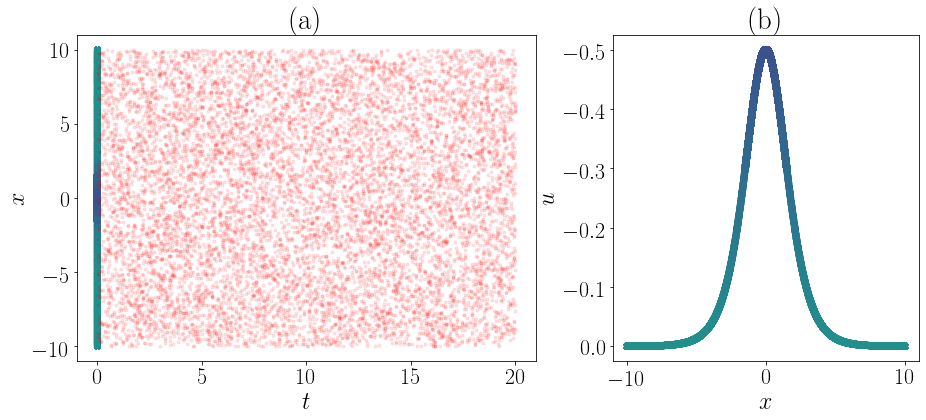

In [ ]:
if plot == True:
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15.1, 6),
                                 gridspec_kw={
                                     'width_ratios': [9, 6],
                                     'wspace': 0.2})
  
  ax1.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax1.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
  ax1.set_xlabel('$t$')
  ax1.set_ylabel('$x$')
  ax1.set_title('(a)')

  ax2.scatter(x_0, u_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax2.set_xlabel('$x$')
  ax2.set_ylabel('$u$')
  ax2.invert_yaxis()
  ax2.set_title('(b)')

  # plt.savefig('kdv_eqn_fwd_train.pdf', dpi=600, bbox_inches='tight', facecolor='none')
  plt.show()

### Persiapan Arsitektur PINN

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

Pada *hidden layer* pertama, terdapat $2 \times 20 = 40$ parameter bobot dan $20$ parameter bias. Pada 9 *hidden layer* selanjutnya, terdapat $20 \times 20 = 400$ parameter bobot dan $20$ parameter bias dalam setiap *layer*. Di *output layer* yang terhubung *hidden layer* terakhir, terdapat $1 \times 20 = 20$ parameter bobot dan $20$ parameter bias. 

Maka, terdapat sejumlah
    \begin{align*}
        1 \times (40+20) + 9 \times (400+20) + 1 \times (20+20) = 3880
    \end{align*}
parameter yang dapat ditentukan dan diperbarui pada setiap *epoch* dalam PINN.

Akan dibuat sebuah model yang mana bobot-bobot inisialnya akan dimuat pada setiap model yang akan dikembangkan dengan *optimizer* L-BFGS, SGD, dan Adam. Hal ini dilakukan agar analisis hasil kinerja dapat dilakukan dengan adil dikarenakan proses *learning* yang dilakukan dengan kondisi yang sama untuk setiap kasus (inisialisai model *apple to apple*).

In [ ]:
# Setting parameters for model's architecture
arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}

In [ ]:
tf.random.set_seed(1)

# Initializing model weights which will be copied to other models
model = pinn.PINN_NeuralNet(lb, ub, **arch)
model.build(input_shape=(None,2))

In [ ]:
model_LBFGS = pinn.PINN_NeuralNet(lb, ub, **arch)
model_LBFGS.build(input_shape=(None,2))

model_SGD_exp = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_exp.build(input_shape=(None,2))

model_SGD_pw = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_pw.build(input_shape=(None,2))

model_SGD_comb = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_comb.build(input_shape=(None,2))

model_Adam_exp = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_exp.build(input_shape=(None,2))

model_Adam_pw = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_pw.build(input_shape=(None,2))

model_Adam_comb = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_comb.build(input_shape=(None,2))

In [ ]:
# Copying weights
model_LBFGS.set_weights(model.get_weights())
model_SGD_exp.set_weights(model.get_weights())
model_SGD_pw.set_weights(model.get_weights())
model_SGD_comb.set_weights(model.get_weights())
model_Adam_exp.set_weights(model.get_weights())
model_Adam_pw.set_weights(model.get_weights())
model_Adam_comb.set_weights(model.get_weights())

### Persiapan Perhitungan *Loss Function*

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the kdv equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [ ]:
def get_r(t, x, model, fun_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape1:  
        
        tape1.watch(x)        
        with tf.GradientTape(persistent=True) as tape2:
          
          tape2.watch(x)
          with tf.GradientTape(persistent=True) as tape3:
          
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape3.watch(t)
            tape3.watch(x)
          
            # Determine residual 
            u = model(tf.stack([t[:,0], x[:,0]], axis=1))

          # Compute gradient u_x and u_t
          u_t = tape3.gradient(u, t)
          u_x = tape3.gradient(u, x)       
        
        u_xx = tape2.gradient(u_x, x)
    
    u_xxx = tape1.gradient(u_xx, x)

    del tape1
    del tape2
    del tape3

    return fun_r(t, x, u, u_t, u_x, u_xx, u_xxx)

## 2. Persiapan *Optimizer*

In [ ]:
# Preparing learning rates
lr_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=150,
    decay_rate=0.9)

lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,4000],
                                                             [1e-2,1e-3,5e-4,2.5e-5])

lr_comb = CombinedDecay(boundaries=[3000,4000],
                        initial_learning_rate=1e-2,
                        decay_steps=150,
                        decay_rate=0.9,
                        values_steps=2)

# Preparing the optimizer
optim_SGD_exp = tf.keras.optimizers.SGD(learning_rate=lr_exp)
optim_Adam_exp = tf.keras.optimizers.Adam(learning_rate=lr_exp)

optim_SGD_pw = tf.keras.optimizers.SGD(learning_rate=lr_pw)
optim_Adam_pw = tf.keras.optimizers.Adam(learning_rate=lr_pw)

optim_SGD_comb = tf.keras.optimizers.SGD(learning_rate=lr_comb)
optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb)

In [ ]:
lr_comb.get_config()

{'initial_learning_rate': 0.01,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [3000, 4000],
 'values': [0.0012157665459056935,
  0.0006078832729528468,
  0.0003039416364764234],
 'values_steps': [2, 2],
 'name': None}

## 3. *Training* Model dan Prediksi Solusi

In [ ]:
# Setting learning timeout
timeout = 100

# Initilize PINN solver
solver_LBFGS = pinn.PINN_PDESolver(model_LBFGS, X_r, fun_r, get_r)

solver_SGD_exp = pinn.PINN_PDESolver(model_SGD_exp, X_r, fun_r, get_r)
solver_SGD_pw = pinn.PINN_PDESolver(model_SGD_pw, X_r, fun_r, get_r)
solver_SGD_comb = pinn.PINN_PDESolver(model_SGD_comb, X_r, fun_r, get_r)

solver_Adam_exp = pinn.PINN_PDESolver(model_Adam_exp, X_r, fun_r, get_r)
solver_Adam_pw = pinn.PINN_PDESolver(model_Adam_pw, X_r, fun_r, get_r)
solver_Adam_comb = pinn.PINN_PDESolver(model_Adam_comb, X_r, fun_r, get_r)

###Adam

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_exp.solve_with_TFoptimizer(optim_Adam_exp, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 4.54140082e-01 l_f = 1.51734066e-03 loss = 4.55657423e-01
It 00050: l_u = 5.63962618e-04 l_f = 1.75045850e-03 loss = 2.31442112e-03
It 00100: l_u = 9.73051647e-05 l_f = 1.15719123e-03 loss = 1.25449640e-03
It 00150: l_u = 6.96461066e-05 l_f = 9.02395637e-04 loss = 9.72041744e-04
It 00200: l_u = 1.26412488e-05 l_f = 8.32016871e-04 loss = 8.44658120e-04
It 00250: l_u = 1.31234410e-05 l_f = 4.74926434e-04 loss = 4.88049875e-04
It 00300: l_u = 6.49848662e-05 l_f = 2.86101829e-04 loss = 3.51086695e-04
It 00350: l_u = 1.07852393e-05 l_f = 3.19523679e-04 loss = 3.30308918e-04
It 00400: l_u = 5.15264401e-06 l_f = 2.26118515e-04 loss = 2.31271159e-04
It 00450: l_u = 1.28305837e-05 l_f = 2.23653959e-04 loss = 2.36484542e-04
It 00500: l_u = 3.76118987e-06 l_f = 1.64177603e-04 loss = 1.67938793e-04
It 00550: l_u = 3.62360151e-06 l_f = 1.33612368e-04 loss = 1.37235969e-04
It 00600: l_u = 3.58058605e-06 l_f = 1.12206457e-04 loss = 1.15787043e-04
It

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_pw.solve_with_TFoptimizer(optim_Adam_pw, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 9.93224807e+00 l_f = 1.51734066e-03 loss = 9.93376541e+00
It 00050: l_u = 2.06174402e+00 l_f = 6.58881217e-02 loss = 2.12763214e+00
It 00100: l_u = 2.02238971e+00 l_f = 5.14001213e-02 loss = 2.07378983e+00
It 00150: l_u = 1.30618241e+00 l_f = 3.34019154e-01 loss = 1.64020157e+00
It 00200: l_u = 1.40115497e+00 l_f = 1.32748872e-01 loss = 1.53390384e+00
It 00250: l_u = 2.21295812e+00 l_f = 7.61727802e-04 loss = 2.21371984e+00
It 00300: l_u = 2.09260346e+00 l_f = 2.20873225e-02 loss = 2.11469078e+00
It 00350: l_u = 2.16737014e+00 l_f = 2.98492331e-02 loss = 2.19721937e+00
It 00400: l_u = 6.30478668e+00 l_f = 1.26635075e+01 loss = 1.89682941e+01
It 00450: l_u = 5.62521797e+00 l_f = 6.63329542e-01 loss = 6.28854752e+00
It 00500: l_u = 5.12148440e+00 l_f = 3.41380000e-01 loss = 5.46286440e+00
It 00550: l_u = 4.68862900e+00 l_f = 2.59536415e-01 loss = 4.94816542e+00
It 00600: l_u = 4.31066500e+00 l_f = 2.08866730e-01 loss = 4.51953173e+00
It

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, timeout=timeout)

# Print computation time

print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 2.15055e-03
It 02200: l_u = 1.76097540e+01 l_f = 2.15669006e-05 loss = 1.76097755e+01


KeyboardInterrupt: ignored

### Grafik *Loss*

In [ ]:
hist_LBFGS = solver_LBFGS.hist
hist_SGD_exp = solver_SGD_exp.hist
hist_SGD_pw = solver_SGD_pw.hist
hist_SGD_comb = solver_SGD_comb.hist
hist_Adam_exp = solver_Adam_exp.hist
hist_Adam_pw = solver_Adam_pw.hist
hist_Adam_comb = solver_Adam_comb.hist

NameError: ignored

In [ ]:
timeout = 100
x_LBFGS = np.linspace(0, timeout, len(hist_LBFGS))
x_SGD_exp = np.linspace(0, timeout, len(hist_SGD_exp))
x_SGD_pw = np.linspace(0, timeout, len(hist_SGD_pw))
x_SGD_comb = np.linspace(0, timeout, len(hist_SGD_comb))
x_Adam_exp = np.linspace(0, timeout, len(hist_Adam_exp))
x_Adam_pw = np.linspace(0, timeout, len(hist_Adam_pw))
x_Adam_comb = np.linspace(0, timeout, len(hist_Adam_comb))

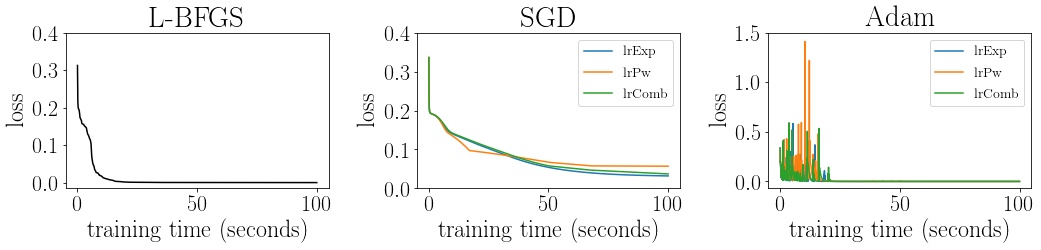

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

ax1.plot(x_LBFGS, hist_LBFGS, c='black')
ax1.set_xlabel('training time (seconds)')
ax1.set_ylabel('loss')
ax1.set_title('L-BFGS')

ax2.plot(x_SGD_exp, hist_SGD_exp)
ax2.plot(x_SGD_pw, hist_SGD_pw)
ax2.plot(x_SGD_comb, hist_SGD_comb)
ax2.legend(['lrExp', 'lrPw', 'lrComb'], fontsize=14)
ax2.set_xlabel('training time (seconds)')
ax2.set_ylabel('loss')
ax2.set_title('SGD')

ax3.plot(x_Adam_exp, hist_Adam_exp)
ax3.plot(x_Adam_pw, hist_Adam_pw)
ax3.plot(x_Adam_comb, hist_Adam_comb)
ax3.legend(['lrExp', 'lrPw', 'lrComb'], fontsize=14)
ax3.set_xlabel('training time (seconds)')
ax3.set_ylabel('loss')
ax3.set_title('Adam')

ax1.set_yticks(np.arange(0, 0.5, 0.1))
ax2.set_yticks(np.arange(0, 0.5, 0.1))
ax3.set_yticks(np.arange(0, 2, 0.5))

plt.tight_layout()
# plt.savefig('kdv_eqn_fwd_loss.pdf', dpi=600, bbox_inches='tight', facecolor='none')
# plt.savefig('kdv_eqn_fwd_loss.png', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

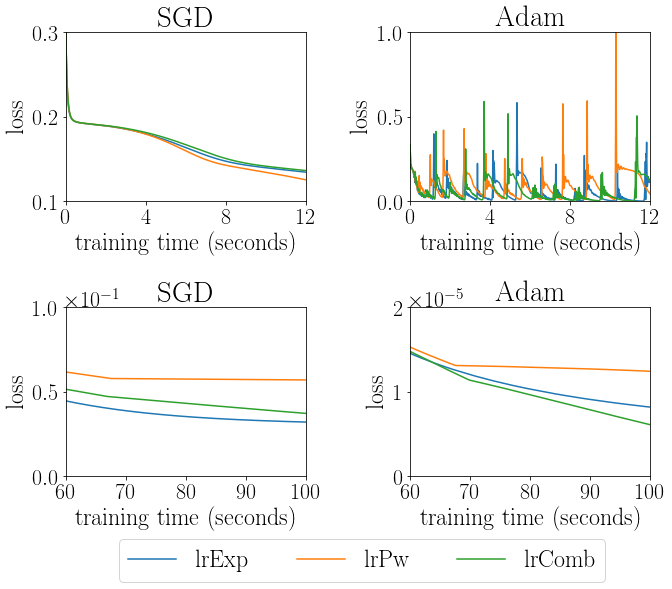

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axs[0][0].plot(x_SGD_exp, hist_SGD_exp, label='lrExp')
axs[0][0].plot(x_SGD_pw, hist_SGD_pw, label='lrPw')
axs[0][0].plot(x_SGD_comb, hist_SGD_comb, label='lrComb')
axs[0][0].set_xlabel('training time (seconds)')
axs[0][0].set_ylabel('loss')
axs[0][0].set_xlim([0, 12])
axs[0][0].set_ylim([0.1, 0.3])
axs[0][0].set_title('SGD')

axs[0][1].plot(x_Adam_exp, hist_Adam_exp, label='lrExp')
axs[0][1].plot(x_Adam_pw, hist_Adam_pw, label='lrPw')
axs[0][1].plot(x_Adam_comb, hist_Adam_comb, label='lrComb')
axs[0][1].set_xlabel('training time (seconds)')
axs[0][1].set_ylabel('loss')
axs[0][1].set_xlim([0, 12])
axs[0][1].set_ylim([0, 1])
axs[0][1].set_title('Adam')

axs[1][0].plot(x_SGD_exp, hist_SGD_exp, label='lrExp')
axs[1][0].plot(x_SGD_pw, hist_SGD_pw, label='lrPw')
axs[1][0].plot(x_SGD_comb, hist_SGD_comb, label='lrComb')
axs[1][0].set_xlabel('training time (seconds)')
axs[1][0].set_ylabel('loss')
axs[1][0].set_xlim([60, 100])
axs[1][0].set_ylim([0, 1e-1])
axs[1][0].set_title('SGD')

axs[1][1].plot(x_Adam_exp, hist_Adam_exp, label='lrExp')
axs[1][1].plot(x_Adam_pw, hist_Adam_pw, label='lrPw')
axs[1][1].plot(x_Adam_comb, hist_Adam_comb, label='lrComb')
axs[1][1].set_xlabel('training time (seconds)')
axs[1][1].set_ylabel('loss')
axs[1][1].set_xlim([60, 100])
axs[1][1].set_ylim([0, 2e-5])
axs[1][1].set_title('Adam')

axs[0][0].set_xticks(np.arange(0, 12+1, 4))
axs[0][1].set_xticks(np.arange(0, 12+1, 4))
axs[1][0].set_xticks(np.arange(60, 100+1, 10))
axs[1][1].set_xticks(np.arange(60, 100+1, 10))
axs[1][0].ticklabel_format(axis='y', scilimits=(0,0))
axs[1][1].ticklabel_format(axis='y', scilimits=(0,0))

plt.tight_layout()
axs[1][1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.3), ncol=3)

# plt.savefig('kdv_eqn_fwd_loss_detailed.pdf', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

### Solusi Model

In [ ]:
Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

Solusi L-BFGS

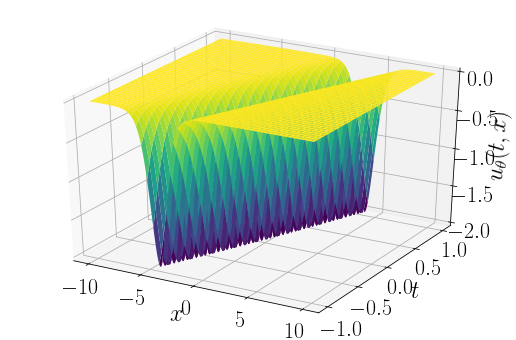

In [ ]:
u_LBFGS = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_LBFGS)

Solusi SGD

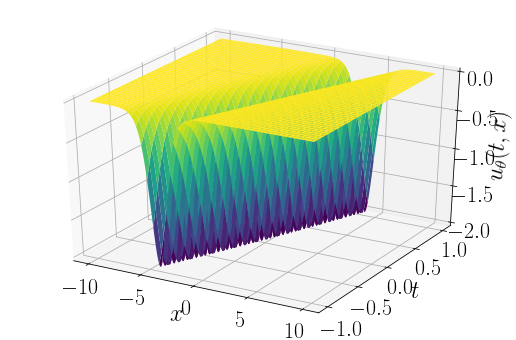

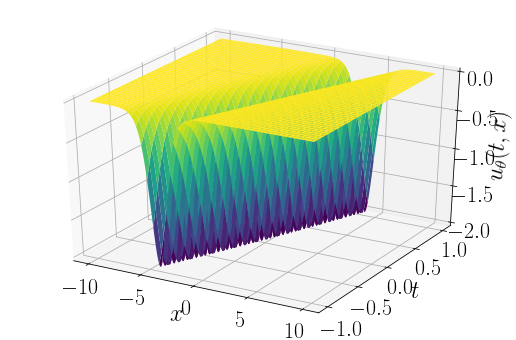

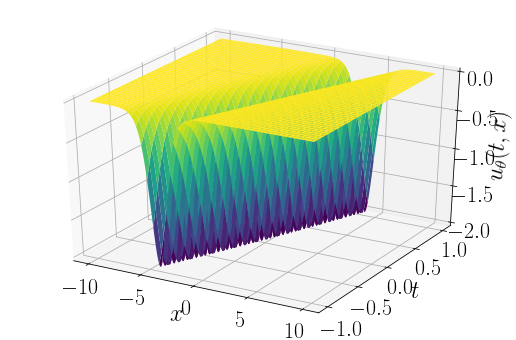

In [ ]:
u_SGD_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_exp)
u_SGD_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_pw)
u_SGD_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_comb)

Solusi Adam

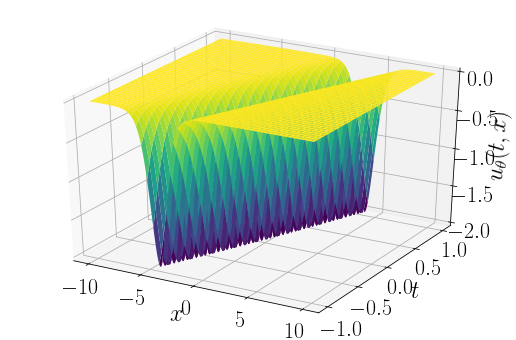

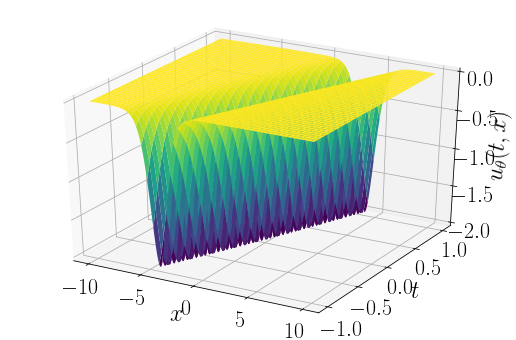

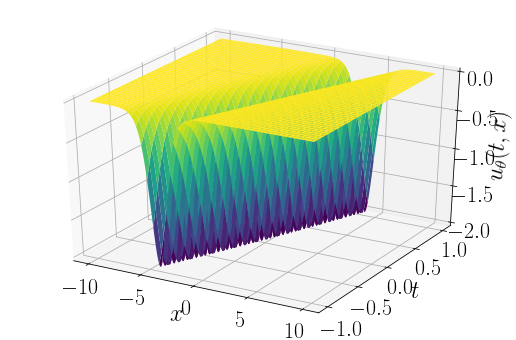

In [ ]:
u_Adam_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_exp)
u_Adam_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_pw)
u_Adam_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_comb)

### *Export Trained* Model

In [ ]:
path = dir + "/model weights/kdv_eqn_fwd"

model_LBFGS.save_weights(path+"/model_LBFGS.h5", 'h5')
model_SGD_exp.save_weights(path+"/model_SGD_exp.h5", 'h5')
model_SGD_pw.save_weights(path+"/model_SGD_pw.h5", 'h5')
model_SGD_comb.save_weights(path+"/model_SGD_comb.h5", 'h5')
model_Adam_exp.save_weights(path+"/model_Adam_exp.h5", 'h5')
model_Adam_pw.save_weights(path+"/model_Adam_pw.h5", 'h5')
model_Adam_comb.save_weights(path+"/model_Adam_comb.h5", 'h5')

In [ ]:
np.savetxt(path+"/loss/hist_LBFGS.txt", solver_LBFGS.hist)
np.savetxt(path+"/loss/hist_SGD_exp.txt", solver_SGD_exp.hist)
np.savetxt(path+"/loss/hist_SGD_pw.txt", solver_SGD_pw.hist)
np.savetxt(path+"/loss/hist_SGD_comb.txt", solver_SGD_comb.hist)
np.savetxt(path+"/loss/hist_Adam_exp.txt", solver_Adam_exp.hist)
np.savetxt(path+"/loss/hist_Adam_pw.txt", solver_Adam_pw.hist)
np.savetxt(path+"/loss/hist_Adam_comb.txt", solver_Adam_comb.hist)

### *Import Trained* Model

In [ ]:
path = dir + "/model weights/kdv_eqn_fwd"
model_LBFGS.load_weights(path+"/model_LBFGS.h5")
model_SGD_exp.load_weights(path+"/model_SGD_exp.h5")
model_SGD_pw.load_weights(path+"/model_SGD_pw.h5")
model_SGD_comb.load_weights(path+"/model_SGD_comb.h5")
model_Adam_exp.load_weights(path+"/model_Adam_exp.h5")
model_Adam_pw.load_weights(path+"/model_Adam_pw.h5")
model_Adam_comb.load_weights(path+"/model_Adam_comb.h5")

hist_LBFGS = np.loadtxt(path+"/loss/hist_LBFGS.txt")
hist_SGD_exp = np.loadtxt(path+"/loss/hist_SGD_exp.txt")
hist_SGD_pw = np.loadtxt(path+"/loss/hist_SGD_pw.txt")
hist_SGD_comb = np.loadtxt(path+"/loss/hist_SGD_comb.txt")
hist_Adam_exp = np.loadtxt(path+"/loss/hist_Adam_exp.txt")
hist_Adam_pw = np.loadtxt(path+"/loss/hist_Adam_pw.txt")
hist_Adam_comb = np.loadtxt(path+"/loss/hist_Adam_comb.txt")

# 4. Persamaan Korteweg-de Vries (KdV) 2-Soliton dan Transformasi menjadi *Loss Function*

Persamaan KdV yang akan digunakan adalah

$$
\begin{equation}
    u_t - 6uu_{x} + u_{xxx} = 0, \quad -\infty<x<\infty, \quad t>0
\end{equation}.
$$
Diberikan *initial condition* (IC)
$$
\begin{equation}
    u(x,\,0) = -6sech^2(x).
\end{equation}
$$
Solusi unik masalah ini adalah
$$
\begin{equation}
	        u(x,\;t) = -12 \frac{3+4\cosh{(2x-8t)}+\cosh{(4x-64t)}} {\{3\cosh{(x-28t)}+\cosh{(3x-36t)}\}^2}.
\end{equation}
$$

In [ ]:
lambda_star = [-6, 1]

# Define initial condition
def fun_u_0(x):
    return -6 * 1/(tf.math.cosh(x))**2

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx, u_xxx, lambd = lambda_star):
    return u_t + lambd[0] * u * u_x + lambd[1] * u_xxx

In [ ]:
# Solusi Eksplisit
def u_expl(t, x):
    """Solusi eksplisit persamaan KdV."""
    return -12*(3 + 4*np.cosh(2*x-8*t) + np.cosh(4*x-64*t))/((3*np.cosh(x-28*t) + np.cosh(3*x-36*t))**2)

In [ ]:
# Set boundary
tmin = -0.5
tmax = 5.
# tmin = 0.
tmax = 0
xmin = -10.
xmax = 10.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

def fun_u_0(x):
    t=tmin
    return -12*(3 + 4*tf.cosh(2*x-8*t) + tf.cosh(4*x-64*t))/((3*tf.cosh(x-28*t) + tf.cosh(3*x-36*t))**2)

## 1. Persiapan Pemodelan

### Pembangkitan Data *Training* dan *Collocation Points*

Penentuan Jumlah Data

In [ ]:
# Set number of data points
N_0 = 5000+5000
N_r = 10000

Pembangkitan Data

In [ ]:
plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:
  # Draw uniform sample points for initial boundary data -> titik di batas domain, definisi domain adalah bidang (x,t)
  # t_0 = tf.zeros((N_0,1), dtype=DTYPE)
  t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
  x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
  # x_0 = tf.random.uniform((5000,1), lb[1], ub[1], dtype=DTYPE)
  # x_0 = tf.concat([x_0, tf.random.uniform((5000,1), -1.5, 1.5, dtype=DTYPE)], axis=0)
  X_0 = tf.concat([t_0, x_0], axis=1)

  # Evaluate initial condition at x_0
  u_0 = fun_u_0(x_0)  

  # Collect boundary and inital data in lists
  X_data = [X_0]
  u_data = [u_0]

  # Draw uniformly sampled collocation points -> titik interior domain
  t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
  x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
  X_r = tf.concat([t_r, x_r], axis=1)

elif plot == False:
  X_data, u_data, fig = pinn.generate_training_data(N_0, N_0, fun_u_0, fun_u_0, lb, ub)
  X_r = pinn.generate_collocation_points(N_r, lb, ub)

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

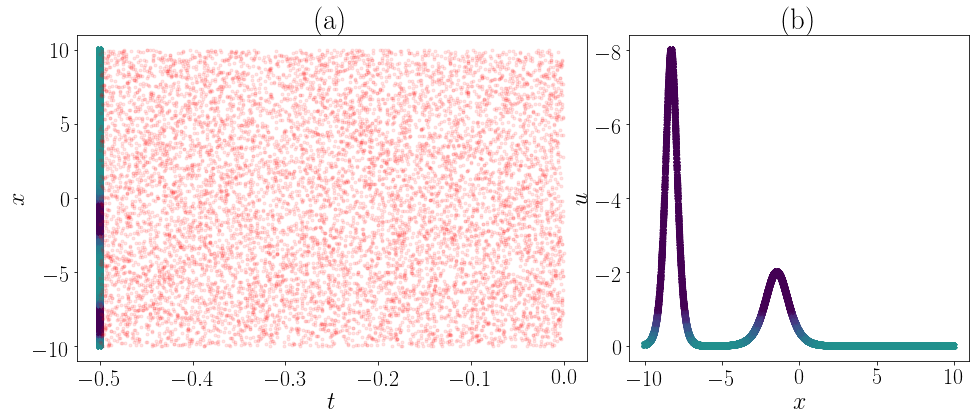

In [ ]:
if plot == True:
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6),
                                 gridspec_kw={
                                     'width_ratios': [9, 6],
                                     'wspace': 0.1})
  
  ax1.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax1.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
  ax1.set_xlabel('$t$')
  ax1.set_ylabel('$x$')
  ax1.set_title('(a)')

  ax2.scatter(x_0, u_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax2.set_xlabel('$x$')
  ax2.set_ylabel('$u$')
  ax2.invert_yaxis()
  ax2.set_title('(b)')

  # plt.savefig('kdv_eqn_fwd_train.pdf', dpi=600, bbox_inches='tight', facecolor='none')
  plt.show()

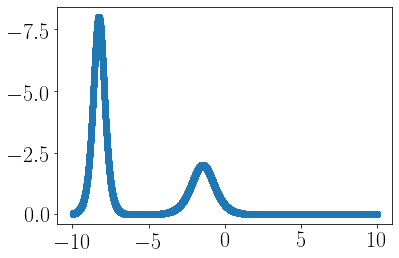

In [ ]:
plt.scatter(x_0, u_0)
plt.gca().invert_yaxis()

plt.show()

### Persiapan Arsitektur PINN

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

Pada *hidden layer* pertama, terdapat $2 \times 20 = 40$ parameter bobot dan $20$ parameter bias. Pada 9 *hidden layer* selanjutnya, terdapat $20 \times 20 = 400$ parameter bobot dan $20$ parameter bias dalam setiap *layer*. Di *output layer* yang terhubung *hidden layer* terakhir, terdapat $1 \times 20 = 20$ parameter bobot dan $20$ parameter bias. 

Maka, terdapat sejumlah
    \begin{align*}
        1 \times (40+20) + 9 \times (400+20) + 1 \times (20+20) = 3880
    \end{align*}
    parameter yang dapat ditentukan dan diperbarui pada setiap *epoch* dalam PINN.

In [ ]:
# Initialize model aka u_\theta
arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}
n_models = 5

In [ ]:
# Set up model architecture & 
# initialize weights to be copied to other models

models = [None] * n_models

for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.PINN_NeuralNet(lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

### Persiapan Perhitungan *Loss Function*

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the kdv equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [ ]:
def get_r(t, x, model, fun_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape1:  
        
        tape1.watch(x)        
        with tf.GradientTape(persistent=True) as tape2:
          
          tape2.watch(x)
          with tf.GradientTape(persistent=True) as tape3:
          
            # Variables t and x are watched during tape
            # to compute derivatives u_t and u_x
            tape3.watch(t)
            tape3.watch(x)
          
            # Determine residual 
            u = model(tf.stack([t[:,0], x[:,0]], axis=1))

          # Compute gradient u_x and u_t
          u_t = tape3.gradient(u, t)
          u_x = tape3.gradient(u, x)       
        
        u_xx = tape2.gradient(u_x, x)
    
    u_xxx = tape1.gradient(u_xx, x)

    del tape1
    del tape2
    del tape3

    return fun_r(t, x, u, u_t, u_x, u_xx, u_xxx)


# # Alternative with tf.gradients
# def fwd_gradients(U, x):
#   return tf.gradients(U, x)[0]

# @tf.function  
# def get_r(t, x, model, fun_r):
#   u = model(tf.stack([t[:,0], x[:,0]], axis=1))
#   u_t = fwd_gradients(u, t)
#   u_x = fwd_gradients(u, x)
#   u_xx = fwd_gradients(u_x, x)
#   u_xxx = fwd_gradients(u_xx, x)

#   return fun_r(t, x, u, u_t, u_x, u_xx, u_xxx)

## 2. Persiapan *Optimizer*

In [ ]:
# Preparing learning rates
lr_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=450,
    decay_rate=0.9)

lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,9000],[1e-2,1e-3,5e-4])

lr_comb = CombinedDecay(boundaries=[1000,3000],
                        initial_learning_rate=1e-2,
                        decay_steps=150,
                        decay_rate=0.9,
                        values_steps=[4,20])

lr_comb.get_config()

{'initial_learning_rate': 0.01,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [1000, 3000],
 'values': [0.004953932250589875,
  0.0012384830626474687,
  6.192415313237344e-05],
 'values_steps': [4, 20],
 'name': None}

## Membuat 5 Buah Model untuk Masing-Masing *Optimizer*

### Test 1 - Adam

t = [-0.5, 0]



In [ ]:
t0 = time()
mod=pinn.PINN_NeuralNet(lb, ub, **arch)
mod.build(input_shape=(None,2))

mod.set_weights(models[0].get_weights())
optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb)
solver_Adam_comb = pinn.PINN_PDESolver(mod, X_r, fun_r, get_r)

solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, min_loss=1e-3)
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 2.25948858e+00 l_f = 7.54245043e-01 loss = 3.01373363e+00
It 00050: l_u = 1.41821675e+00 l_f = 6.26261979e-02 loss = 1.48084295e+00
It 00100: l_u = 1.09984145e+00 l_f = 3.31611894e-02 loss = 1.13300264e+00
It 00150: l_u = 1.30045014e+00 l_f = 2.71707270e-02 loss = 1.32762086e+00
It 00200: l_u = 2.08432077e+00 l_f = 2.91301543e-03 loss = 2.08723378e+00
It 00250: l_u = 1.85126386e+00 l_f = 1.99151207e-02 loss = 1.87117898e+00
It 00300: l_u = 1.52502173e+00 l_f = 6.00252748e-02 loss = 1.58504701e+00
It 00350: l_u = 1.47942241e+00 l_f = 4.57351655e-02 loss = 1.52515757e+00
It 00400: l_u = 1.46769428e+00 l_f = 4.77888621e-02 loss = 1.51548314e+00
It 00450: l_u = 1.44712815e+00 l_f = 5.15445732e-02 loss = 1.49867272e+00
It 00500: l_u = 1.39016620e+00 l_f = 7.05133304e-02 loss = 1.46067953e+00
It 00550: l_u = 1.33877669e+00 l_f = 8.08667094e-02 loss = 1.41964340e+00
It 00600: l_u = 1.19303358e+00 l_f = 1.03528976e-01 loss = 1.29656255e+00
It

KeyboardInterrupt: ignored

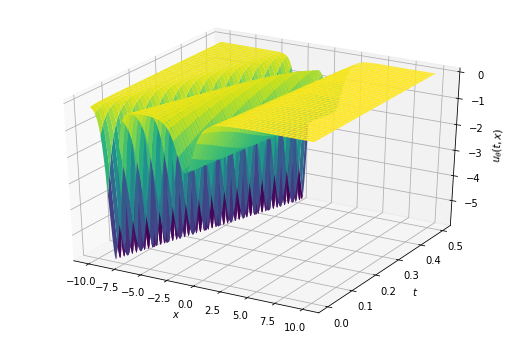

In [ ]:
u_Adam = solver_Adam_comb.predict_solution()
solver_Adam_comb.plot_solution(u_Adam)

In [ ]:
# path = dir + "/Data/"
# u_star = np.loadtxt(path + "u_star_kdv.csv")

Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
tspace = np.linspace(-0.5, 0, Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

# Solusi Eksplisit
u_star = np.empty([len(xspace), len(tspace)])
i = 0
for x_i in xspace:
  j = 0
  for t_i in tspace:    
    u_star[i][j] = u_expl(t_i, x_i); j += 1
  i += 1

pinn.evaluate_solution(solver_Adam_comb.predict_solution(), u_star)

0.7917388156516815

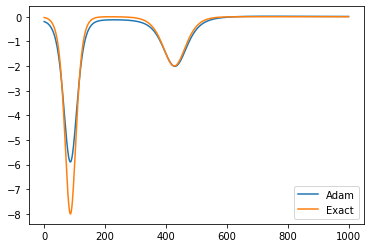

In [ ]:
plt.plot(u_Adam[:,0])
plt.plot(u_star[:,0])

plt.legend(["Adam", "Exact"])
plt.show()

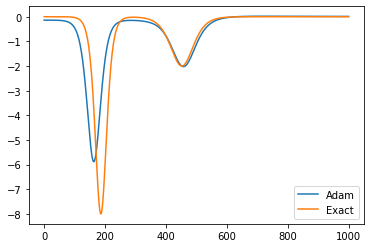

In [ ]:
plt.plot(u_Adam[:,250])
plt.plot(u_star[:,250])

plt.legend(["Adam", "Exact"])
plt.show()

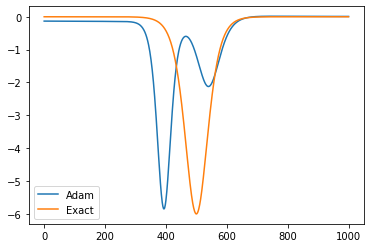

In [ ]:
plt.plot(u_Adam[:,-1])
plt.plot(u_star[:,-1])

plt.legend(["Adam", "Exact"])
plt.show()

### Test 2 - Adam

t = [0, 0.5]



In [ ]:
t0 = time()
mod=pinn.PINN_NeuralNet(lb, ub, **arch)
mod.build(input_shape=(None,2))

mod.set_weights(models[0].get_weights())
optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb)
solver_Adam_comb = pinn.PINN_PDESolver(mod, X_r, fun_r, get_r)

solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, min_loss=1e-3)
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: loss = 8.84157276e+00
It 00050: loss = 1.41734338e+00
It 00100: loss = 1.15146184e+00
It 00150: loss = 2.59514976e+00
It 00200: loss = 9.16779995e-01
It 00250: loss = 8.16292882e-01
It 00300: loss = 8.88623953e-01
It 00350: loss = 1.15666831e+00
It 00400: loss = 2.06064367e+00
It 00450: loss = 6.66007459e-01
It 00500: loss = 9.32118893e-01
It 00550: loss = 6.17645860e-01
It 00600: loss = 5.81460834e-01
It 00650: loss = 5.34664273e-01
It 00700: loss = 7.95597076e-01
It 00750: loss = 4.32624012e-01
It 00800: loss = 5.47725976e-01
It 00850: loss = 2.93170047e+00
It 00900: loss = 6.20325565e-01
It 00950: loss = 4.28271800e-01
It 01000: loss = 5.40619493e-01
It 01050: loss = 4.61138815e-01
It 01100: loss = 4.31311727e-01
It 01150: loss = 4.10224676e-01
It 01200: loss = 3.93182933e-01
It 01250: loss = 3.78401041e-01
It 01300: loss = 3.65818053e-01
It 01350: loss = 3.55466247e-01
It 01400: loss = 3.46753120e-01
It 01450: loss = 3.39117199e-01
It 0

KeyboardInterrupt: ignored

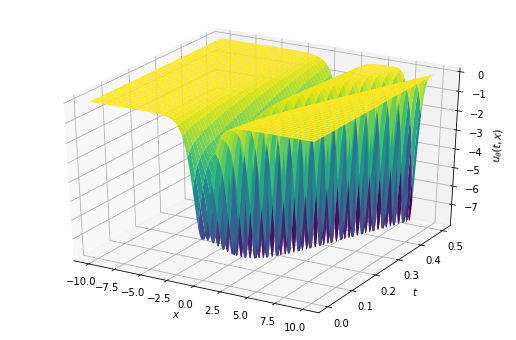

In [ ]:
u_Adam = solver_Adam_comb.predict_solution()
solver_Adam_comb.plot_solution(u_Adam)

In [ ]:
# path = dir + "/Data/"
# u_star = np.loadtxt(path + "u_star_kdv.csv")

Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
tspace = np.linspace(0, 0.5, Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

# Solusi Eksplisit
u_star = np.empty([len(xspace), len(tspace)])
i = 0
for x_i in xspace:
  j = 0
  for t_i in tspace:    
    u_star[i][j] = u_expl(t_i, x_i); j += 1
  i += 1

pinn.evaluate_solution(solver_Adam_comb.predict_solution(), u_star)

1.3989651739071056

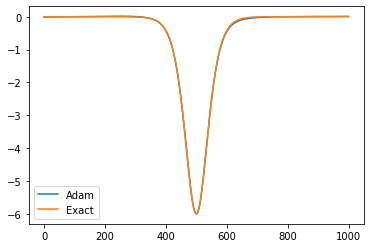

In [ ]:
plt.plot(u_Adam[:,0])
plt.plot(u_star[:,0])

plt.legend(["Adam", "Exact"])
plt.show()

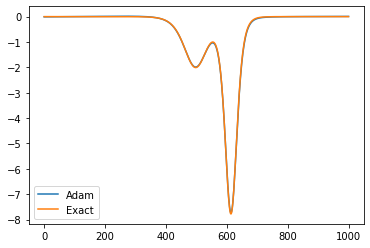

In [ ]:
plt.plot(u_Adam[:,250])
plt.plot(u_star[:,250])

plt.legend(["Adam", "Exact"])
plt.show()

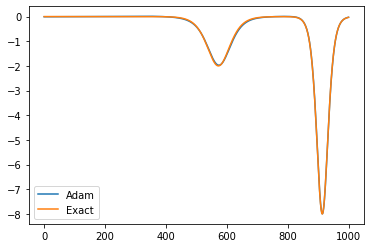

In [ ]:
plt.plot(u_Adam[:,-1])
plt.plot(u_star[:,-1])

plt.legend(["Adam", "Exact"])
plt.show()

In [ ]:
t0 = time()
mod=pinn.PINN_NeuralNet(lb, ub, **arch)
mod.build(input_shape=(None,2))

mod.set_weights(models[0].get_weights())
optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb)
solver_Adam_comb = pinn.PINN_PDESolver(mod, X_r, fun_r, get_r)

solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, min_loss=1e-3)
print('\nComputation time: {} seconds'.format(time()-t0))

In [ ]:
timeout = 60*5

path = dir + "/model weights/kdv_eqn_fwd"
models_LBFGS = []
models_SGD_exp = []
models_SGD_pw = []
models_SGD_comb = []
models_Adam_exp = []
models_Adam_pw = []
models_Adam_comb = []
hists_LBFGS = []
hists_SGD_exp = []
hists_SGD_pw = []
hists_SGD_comb = []
hists_Adam_exp = []
hists_Adam_pw = []
hists_Adam_comb = []


for i in range(n_models):
  print('{:s}\nIteration: {:d}\n{:s}'.format(50*'-',i+1,50*'-'))

  tf.random.set_seed(i)
  models_LBFGS.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))

  models_LBFGS[i].build(input_shape=(None,2))
  models_SGD_exp[i].build(input_shape=(None,2))
  models_SGD_pw[i].build(input_shape=(None,2))
  models_SGD_comb[i].build(input_shape=(None,2))
  models_Adam_exp[i].build(input_shape=(None,2))
  models_Adam_pw[i].build(input_shape=(None,2))
  models_Adam_comb[i].build(input_shape=(None,2))

  # Copy weights from the previous model instance to make every iteration comparable  
  models_LBFGS[i].set_weights(models[i].get_weights())
  models_SGD_exp[i].set_weights(models[i].get_weights())
  models_SGD_pw[i].set_weights(models[i].get_weights())
  models_SGD_comb[i].set_weights(models[i].get_weights())
  models_Adam_exp[i].set_weights(models[i].get_weights())
  models_Adam_pw[i].set_weights(models[i].get_weights())
  models_Adam_comb[i].set_weights(models[i].get_weights())

  # Prepare optimizers
  optim_SGD_exp = tf.keras.optimizers.SGD(learning_rate=lr_exp)
  optim_SGD_pw = tf.keras.optimizers.SGD(learning_rate=lr_pw)
  optim_SGD_comb = tf.keras.optimizers.SGD(learning_rate=lr_comb)
  optim_Adam_exp = tf.keras.optimizers.Adam(learning_rate=lr_exp)
  optim_Adam_pw = tf.keras.optimizers.Adam(learning_rate=lr_pw)
  optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb) 

  # Initialize solvers
  solver_LBFGS = pinn.PINN_PDESolver(models_LBFGS[i], X_r, fun_r, get_r)
  solver_SGD_exp = pinn.PINN_PDESolver(models_SGD_exp[i], X_r, fun_r, get_r)
  solver_SGD_pw = pinn.PINN_PDESolver(models_SGD_pw[i], X_r, fun_r, get_r)
  solver_SGD_comb = pinn.PINN_PDESolver(models_SGD_comb[i], X_r, fun_r, get_r)
  solver_Adam_exp = pinn.PINN_PDESolver(models_Adam_exp[i], X_r, fun_r, get_r)
  solver_Adam_pw = pinn.PINN_PDESolver(models_Adam_pw[i], X_r, fun_r, get_r)
  solver_Adam_comb = pinn.PINN_PDESolver(models_Adam_comb[i], X_r, fun_r, get_r)

  # Train models
  print('\n\nL-BFGS\n')
  solver_LBFGS.solve_with_ScipyOptimizer(X_data, u_data,
                                        timeout=timeout,
                                        method='L-BFGS-B')
  print('\n\nSGD - Exponential Decay\n')
  solver_SGD_exp.solve_with_TFoptimizer(optim_SGD_exp, X_data, u_data, timeout=timeout)
  print('\n\nSGD - Piecewise Constant Decay\n')
  solver_SGD_pw.solve_with_TFoptimizer(optim_SGD_pw, X_data, u_data, timeout=timeout)
  print('\n\nSGD - Combined Learning Rate\n')
  solver_SGD_comb.solve_with_TFoptimizer(optim_SGD_comb, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Exponential Decay\n')
  solver_Adam_exp.solve_with_TFoptimizer(optim_Adam_exp, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Piecewise Constant Decay\n')
  solver_Adam_pw.solve_with_TFoptimizer(optim_Adam_pw, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Combined Learning Rate\n')
  solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, timeout=timeout)
  
  # Store evolution of lambdas and hists
  hists_LBFGS.append(solver_LBFGS.hist)
  hists_SGD_exp.append(solver_SGD_exp.hist)
  hists_SGD_pw.append(solver_SGD_pw.hist)
  hists_SGD_comb.append(solver_SGD_comb.hist)
  hists_Adam_exp.append(solver_Adam_exp.hist)
  hists_Adam_pw.append(solver_Adam_pw.hist)
  hists_Adam_comb.append(solver_Adam_comb.hist)

  print('\n\n\n')    
  models_LBFGS[i].save_weights(path+"_"+str(i)+"/model_LBFGS.h5", 'h5')
  models_SGD_exp[i].save_weights(path+"_"+str(i)+"/model_SGD_exp.h5", 'h5')
  models_SGD_pw[i].save_weights(path+"_"+str(i)+"/model_SGD_pw.h5", 'h5')
  models_SGD_comb[i].save_weights(path+"_"+str(i)+"/model_SGD_comb.h5", 'h5')
  models_Adam_exp[i].save_weights(path+"_"+str(i)+"/model_Adam_exp.h5", 'h5')
  models_Adam_pw[i].save_weights(path+"_"+str(i)+"/model_Adam_pw.h5", 'h5')
  models_Adam_comb[i].save_weights(path+"_"+str(i)+"/model_Adam_comb.h5", 'h5')

  np.savetxt(path+"_"+str(i)+"/loss/hist_LBFGS.txt", hists_LBFGS[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_exp.txt", hists_SGD_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_pw.txt", hists_SGD_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_comb.txt", hists_SGD_comb[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_exp.txt", hists_Adam_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_pw.txt", hists_Adam_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_comb.txt", hists_Adam_comb[i])

### *Export* Model

*Export* bobot dan bias yang diperoleh pada *training*.

In [ ]:
path = dir + "/model weights/kdv_eqn_fwd"

for i in range(n_models):  
	models_LBFGS[i].save_weights(path+"_"+str(i)+"/model_LBFGS.h5", 'h5')
	models_SGD_exp[i].save_weights(path+"_"+str(i)+"/model_SGD_exp.h5", 'h5')
	models_SGD_pw[i].save_weights(path+"_"+str(i)+"/model_SGD_pw.h5", 'h5')
	models_SGD_comb[i].save_weights(path+"_"+str(i)+"/model_SGD_comb.h5", 'h5')
	models_Adam_exp[i].save_weights(path+"_"+str(i)+"/model_Adam_exp.h5", 'h5')
	models_Adam_pw[i].save_weights(path+"_"+str(i)+"/model_Adam_pw.h5", 'h5')
	models_Adam_comb[i].save_weights(path+"_"+str(i)+"/model_Adam_comb.h5", 'h5')

*Export* riwayat *loss* pada *training* dalam bentuk `hist`.

In [ ]:
for i in range(n_models):
  np.savetxt(path+"_"+str(i)+"/loss/hist_LBFGS.txt", hists_LBFGS[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_exp.txt", hists_SGD_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_pw.txt", hists_SGD_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_comb.txt", hists_SGD_comb[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_exp.txt", hists_Adam_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_pw.txt", hists_Adam_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_comb.txt", hists_Adam_comb[i])

## 4. Prediksi Solusi dan Evaluasi Kinerja Model

In [ ]:
Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

In [ ]:
print("Koordinat x, 5 elemen pertama:", list(xspace[:5]))
print("Koordinat x, 5 elemen terakhir:", list(xspace[-5:]), "\n")

print("Koordinat t, 5 elemen pertama:", list(tspace[:5]))

print("Koordinat t, 5 elemen terakhir:", list(tspace[-5:]), "\n")

Koordinat x, 5 elemen pertama: [-10.0, -9.98, -9.96, -9.94, -9.92]
Koordinat x, 5 elemen terakhir: [9.920000000000002, 9.940000000000001, 9.96, 9.98, 10.0] 

Koordinat t, 5 elemen pertama: [-0.5, -0.499, -0.498, -0.497, -0.496]
Koordinat t, 5 elemen terakhir: [0.496, 0.497, 0.498, 0.499, 0.5] 



### Solusi Eksplisit

Solusi analitik untuk persamaan panas.

In [ ]:
path = dir + "/Data/"

# # Solusi Eksplisit
# u_star = np.empty([len(xspace), len(tspace)])
# i = 0
# for x_i in xspace:
#   j = 0
#   for t_i in tspace:    
#     u_star[i][j] = u_expl(t_i, x_i); j += 1
#   i += 1

# np.savetxt(path + "u_star_kdv.csv", u_star)

u_star = np.loadtxt(path + "u_star_kdv.csv")

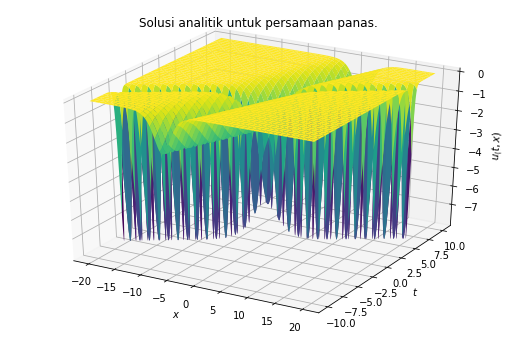

In [ ]:
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u_star, cmap='viridis');
# ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_(t,x)$')
ax.set_title('Solusi analitik untuk persamaan panas.');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

### Solusi Model

Solusi L-BFGS

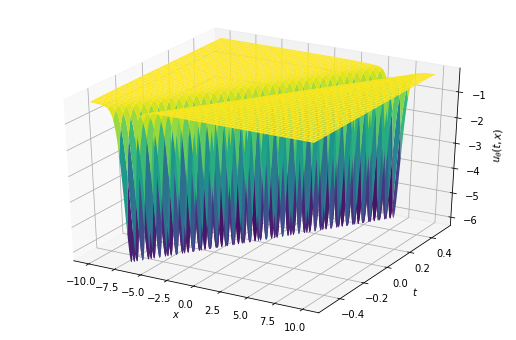

In [ ]:
u_LBFGS = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_LBFGS)

Solusi SGD

In [ ]:
u_SGD_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_exp)
u_SGD_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_pw)
u_SGD_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_comb)

Solusi Adam

In [ ]:
u_Adam_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_exp)
u_Adam_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_pw)
u_Adam_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_comb)

### Evaluasi Kinerja Model

*Import* model beserta *loss* dari 5 percobaan pemodelan yang telah dilakukan.

In [ ]:
n_models = 5
path = dir + "/model weights/kdv_eqn_fwd"

arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}
models_LBFGS = []
models_SGD_exp = []
models_SGD_pw = []
models_SGD_comb = []
models_Adam_exp = []
models_Adam_pw = []
models_Adam_comb = []
hists_LBFGS = []
hists_SGD_exp = []
hists_SGD_pw = []
hists_SGD_comb = []
hists_Adam_exp = []
hists_Adam_pw = []
hists_Adam_comb = []


for i in range(n_models):
  models_LBFGS.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))

  models_LBFGS[i].build(input_shape=(None,2))
  models_SGD_exp[i].build(input_shape=(None,2))
  models_SGD_pw[i].build(input_shape=(None,2))
  models_SGD_comb[i].build(input_shape=(None,2))
  models_Adam_exp[i].build(input_shape=(None,2))
  models_Adam_pw[i].build(input_shape=(None,2))
  models_Adam_comb[i].build(input_shape=(None,2))

  models_LBFGS[i].load_weights(path+"_"+str(i)+"/model_LBFGS.h5")
  models_SGD_exp[i].load_weights(path+"_"+str(i)+"/model_SGD_exp.h5")
  models_SGD_pw[i].load_weights(path+"_"+str(i)+"/model_SGD_pw.h5")
  models_SGD_comb[i].load_weights(path+"_"+str(i)+"/model_SGD_comb.h5")
  models_Adam_exp[i].load_weights(path+"_"+str(i)+"/model_Adam_exp.h5")
  models_Adam_pw[i].load_weights(path+"_"+str(i)+"/model_Adam_pw.h5")
  models_Adam_comb[i].load_weights(path+"_"+str(i)+"/model_Adam_comb.h5")

  hists_LBFGS.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_LBFGS.txt"))
  hists_SGD_exp.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_exp.txt"))
  hists_SGD_pw.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_pw.txt"))
  hists_SGD_comb.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_comb.txt"))
  hists_Adam_exp.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_exp.txt"))
  hists_Adam_pw.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_pw.txt"))
  hists_Adam_comb.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_comb.txt"))
  

Prediksi solusi dengan model-model yang telah dibuat.

In [ ]:
preds_LBFGS = []
preds_SGD_exp = []
preds_SGD_pw = []
preds_SGD_comb = []
preds_Adam_exp = []
preds_Adam_pw = []
preds_Adam_comb = []

for i in range(n_models):
  preds_LBFGS.append(pinn.predict_solution(models_LBFGS[i], Nt, Nx))
  preds_SGD_exp.append(pinn.predict_solution(models_SGD_exp[i], Nt, Nx))
  preds_SGD_pw.append(pinn.predict_solution(models_SGD_pw[i], Nt, Nx))
  preds_SGD_comb.append(pinn.predict_solution(models_SGD_comb[i], Nt, Nx))
  preds_Adam_exp.append(pinn.predict_solution(models_Adam_exp[i], Nt, Nx))
  preds_Adam_pw.append(pinn.predict_solution(models_Adam_pw[i], Nt, Nx))
  preds_Adam_comb.append(pinn.predict_solution(models_Adam_comb[i], Nt, Nx))

In [ ]:
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, pinn.predict_solution(models_LBFGS[i], 1000, 1000), cmap='viridis');
# ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_(t,x)$')

NameError: ignored

In [ ]:
df = pd.DataFrame(columns = ['L-BFGS' , 
                             'SGD (exp)', 'SGD (pw)', 'SGD (comb)',  
                             'Adam (exp)', 'Adam (pw)', 'Adam (comb)'])

for i in range(n_models):
  df.loc['Attempt '+str(i+1)] = [pinn.evaluate_solution(preds_LBFGS[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_exp[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_pw[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_comb[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_exp[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_pw[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_comb[i], u_star)]

df

L-BFGS  SGD (exp)  SGD (pw)  SGD (comb)  Adam (exp)  Adam (pw)  \
Attempt 1  1.032583   1.033675  1.013763    1.107484    1.268635   1.078021   
Attempt 2  1.027730   0.999810  1.132227    1.000661    1.092015   1.159308   
Attempt 3  5.545831   5.528092  5.498783    5.541153    5.545125   5.542831   
Attempt 4  5.545831   5.528092  5.498783    5.541153    5.545125   5.542831   
Attempt 5  5.545831   5.528092  5.498783    5.541153    5.545125   5.542831   

           Adam (comb)  
Attempt 1     1.222124  
Attempt 2     1.091489  
Attempt 3     5.543731  
Attempt 4     5.543731  
Attempt 5     5.543731

In [ ]:
df.idxmin(axis=1)

In [ ]:
df.mean(axis=0)

In [ ]:
print(tabulate(df.round(6), headers='firstrow', tablefmt='latex'))

### Grafik *Loss*

In [ ]:
x_LBFGS = np.linspace(0, 300, len(hist_LBFGS))
x_SGD_exp = np.linspace(0, 300, len(hist_SGD_exp))
x_SGD_pw = np.linspace(0, 300, len(hist_SGD_pw))
x_SGD_comb = np.linspace(0, 300, len(hist_SGD_comb))
x_Adam_exp = np.linspace(0, 300, len(hist_Adam_exp))
x_Adam_pw = np.linspace(0, 300, len(hist_Adam_pw))
x_Adam_comb = np.linspace(0, 300, len(hist_Adam_comb))

In [ ]:
plt.plot(x_LBFGS, hist_LBFGS)
plt.xlabel('training time (seconds)')
plt.ylabel('loss')
plt.xlim([0, 300])

plt.show()

In [ ]:
plt.plot(x_SGD_exp, hist_SGD_exp, '--')
plt.plot(x_SGD_pw, hist_SGD_pw, '--')
plt.plot(x_SGD_comb, hist_SGD_comb, '--')
plt.legend(['Exponential Decay', 'Piecewise Function', 'Combined'])
plt.xlabel('training time (seconds)')
plt.ylabel('loss')

plt.show()

In [ ]:
plt.plot(x_Adam_exp, hist_Adam_exp)
plt.plot(x_Adam_pw, hist_Adam_pw)
plt.plot(x_Adam_comb, hist_Adam_comb)
plt.legend(['Exponential Decay', 'Piecewise Function', 'Combined'])
plt.xlabel('time (seconds)')
plt.ylabel('loss')

plt.show()

In [ ]:
plt.plot(x_LBFGS, hist_LBFGS)
plt.plot(x_SGD_comb, hist_SGD_comb)
plt.plot(x_Adam_comb, hist_Adam_comb)
plt.legend(['L-BFGS', 'SGD', 'Adam'])
plt.xlabel('time (seconds)')
plt.ylabel('loss')

plt.show()

In [ ]:
plt.plot(x_LBFGS, hist_LBFGS)
plt.plot(x_SGD_comb, hist_SGD_comb)
plt.plot(x_Adam_comb, hist_Adam_comb)
plt.legend(['L-BFGS', 'SGD', 'Adam'])
plt.xlabel('time (seconds)')
plt.ylabel('loss')
plt.xlim([150, 300])
plt.ylim([0, 10e-3])

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=n_models, ncols=3, figsize=(10,10))

for i in range(n_models):
  axes[i,0].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_SGD_exp[i])), hists_SGD_exp[i])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_Adam_exp[i])), hists_Adam_exp[i])
  
  axes[i,1].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_SGD_pw[i])), hists_SGD_pw[i])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_Adam_pw[i])), hists_Adam_pw[i])

  axes[i,2].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_SGD_comb[i])), hists_SGD_comb[i])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_Adam_comb[i])), hists_Adam_comb[i])

cols = ['Exponential Decay', 'Piecewise Constant Decay', 'Combined Learning Rate']
rows = ['Attempt {}'.format(row) for row in range(1, n_models+1)]

pad = 5 # in points

for ax_row in axes:
  for ax in ax_row:    
    ax.set_xlabel('training time (seconds)')
    ax.set_ylabel('loss')
    ax.set_xlim([150,300])
    ax.set_ylim([0,10e-3])

for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
              xycoords='axes fraction', textcoords='offset points',
              size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
  ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
              xycoords=ax.yaxis.label, textcoords='offset points',
              size='large', ha='right', va='center')

fig.suptitle('$\it{Loss}$ pada Lima Model yang Dikembangkan', y=1.05, fontsize=25)
fig.legend(['L-BFGS', 'SGD', 'Adam'], loc='upper right')

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

plt.savefig("kdv_eqn_fwd_hists.png", dpi=600, bbox_inches='tight')

plt.show()